In [1411]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import tree

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D  
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from scipy import stats
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.colors as pc
from sklearn.ensemble import IsolationForest



# Dataset overview

In [1412]:
data = pd.read_csv('./Dataset_dumarey/original_csv/dataset_original.csv')

In [1413]:
def remove_spaces(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(" ", "")         
    ts = ts.replace("  ", "")        
    ts = ts.replace("   ", "")   
def fix_vin (ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts)
    if ts.startswith('-8.9'):
        return '1.0'
    elif ts.startswith('-2.4'):
        return '2.0'
    elif ts.startswith('·2.4'):
        return '2.0'
    else:
        return ts


In [1414]:
cols_to_float = ['odo', 'end_odo', 'soc', 'end_soc']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], errors='coerce')
 

In [1415]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', dayfirst=False)
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce', dayfirst=False)

In [1416]:
cols_to_convert = ['event']
for col in cols_to_convert:
    data[col] = data[col].astype('category')
data['charge_mode'] = data['charge_mode'].astype('category')

In [1417]:
data['vin'] = data['vin'].apply(fix_vin)
data['vin'] = data['vin'].astype('float64')

In [1418]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          608 non-null    float64       
 1   timestamp    608 non-null    datetime64[ns]
 2   end_time     608 non-null    datetime64[ns]
 3   odo          608 non-null    float64       
 4   end_odo      607 non-null    float64       
 5   soc          605 non-null    float64       
 6   end_soc      607 non-null    float64       
 7   event        608 non-null    category      
 8   charge_mode  608 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 34.9 KB


### Inspect dataset structure

In [1419]:
print(f"Element of the dataset: {len(data)}")
print(f"Columns of the dataset: {data.columns.to_list()}")

Element of the dataset: 608
Columns of the dataset: ['vin', 'timestamp', 'end_time', 'odo', 'end_odo', 'soc', 'end_soc', 'event', 'charge_mode']


In [1420]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          608 non-null    float64       
 1   timestamp    608 non-null    datetime64[ns]
 2   end_time     608 non-null    datetime64[ns]
 3   odo          608 non-null    float64       
 4   end_odo      607 non-null    float64       
 5   soc          605 non-null    float64       
 6   end_soc      607 non-null    float64       
 7   event        608 non-null    category      
 8   charge_mode  608 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 34.9 KB


In [1421]:
data.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc   event charge_mode  
0   56.4     54.9    trip           0  
1   54.9    100.0  charge         240  
2  100.0    100.0    trip           0  
3  100.0     94.5    trip           0  
4   94.5     94.5    trip           0

In [1422]:
#number of values per veicle
vehicle_counts = data['vin'].value_counts()
print(vehicle_counts)
print()
vehicle_counts = data['event'].value_counts()
print(vehicle_counts)
print()
#number of values for the different charge_mode where the event is charge 
charge_mode_counts = data[data['event'] == 'charge']['charge_mode'].value_counts()
print(charge_mode_counts)

vin
1.0    352
2.0    256
Name: count, dtype: int64

event
trip      466
charge    142
Name: count, dtype: int64

charge_mode
240           63
120           48
DCCharging    17
0             14
Name: count, dtype: int64


# Missing values, duplicates and irrelevant rows

### Null values

In [1423]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

print("\n🔍 Rows with missing values:\n")

rows_with_nan = data[data.isna().any(axis=1)]

rows_with_nan.head(len(rows_with_nan))


| Features | NaN-counter |
vin            0
timestamp      0
end_time       0
odo            0
end_odo        1
soc            3
end_soc        1
event          0
charge_mode    0
dtype: int64
|----------|-------------|

🔍 Rows with missing values:



vin           timestamp            end_time          odo      end_odo  \
15   1.0 2021-01-04 17:54:00 2021-01-04 17:54:00  4665.203125  4665.203125   
16   1.0 2021-01-04 17:54:00 2021-01-04 18:16:00  4665.203125  4667.953125   
202  1.0 2021-01-06 19:19:00 2021-01-06 19:35:00  5007.500000  5007.500000   
212  1.0 2021-01-07 21:03:00 2021-01-07 21:49:00  5088.500000  5088.500000   
461  2.0 2021-05-16 17:53:00 2021-05-16 18:10:00  4922.906250          NaN   

      soc  end_soc   event charge_mode  
15   45.0      NaN  charge         240  
16    NaN     44.3    trip           0  
202   NaN     68.6  charge           0  
212   NaN     78.4  charge           0  
461  83.5     81.9    trip           0

### Charge Event with no charge mode


In [1424]:
#number of rows where event == charge and charge_mode = 0
charge_mode_0_count = data[(data['event'] == 'charge') & (data['charge_mode'] == '0')]
print(f"Number of rows where event = 'charge' and charge_mode = '0': {charge_mode_0_count.shape[0]}")
print("\n The rows are:\n")
charge_mode_0_count.head(len(charge_mode_0_count))

Number of rows where event = 'charge' and charge_mode = '0': 14

 The rows are:



vin           timestamp            end_time           odo       end_odo  \
86   2.0 2021-05-04 15:45:00 2021-05-04 17:46:00   2734.281250   2734.281250   
193  1.0 2021-01-06 14:39:00 2021-01-06 15:11:00   4975.343750   4975.343750   
202  1.0 2021-01-06 19:19:00 2021-01-06 19:35:00   5007.500000   5007.500000   
212  1.0 2021-01-07 21:03:00 2021-01-07 21:49:00   5088.500000   5088.500000   
244  1.0 2021-01-13 19:22:00 2021-01-13 19:30:00   5996.968750   5996.968750   
271  1.0 2021-01-15 15:41:00 2021-01-15 19:45:00   6445.078125   6445.078125   
301  1.0 2021-01-20 21:51:00 2021-01-20 22:38:00   7000.187500   7000.187500   
352  1.0 2021-01-28 14:22:00 2021-01-28 14:51:00   8172.593750   8172.593750   
364  1.0 2021-01-29 15:48:00 2021-01-29 16:34:00   8386.171875   8386.171875   
395  1.0 2021-02-04 14:42:00 2021-02-04 22:47:00   9014.000000   9014.000000   
408  1.0 2021-02-06 16:37:00 2021-02-06 21:44:00   9217.203125   9217.203125   
487  2.0 2021-05-18 21:09:00 2021-05-18 22:10:00   5662.734375   5662.734375   
527  2.0 2021-05-21 22:17:00 2021-05-21 22:35:00   6816.406250   6816.406250   
575  1.0 2021-02-25 17:56:00 2021-02-25 18:46:00  10730.671880  10730.671880   

      soc  end_soc   event charge_mode  
86   10.5     12.5  charge           0  
193  59.6     64.3  charge           0  
202   NaN     68.6  charge           0  
212   NaN     78.4  charge           0  
244  41.5     50.1  charge           0  
271  45.8     52.5  charge           0  
301  38.0     79.6  charge           0  
352  45.4     67.0  charge           0  
364  28.2     74.5  charge           0  
395  23.5     74.5  charge           0  
408  32.1     63.9  charge           0  
487  32.1     81.5  charge           0  
527  36.0     36.0  charge           0  
575  92.1     92.1  charge           0

In [1425]:
#print all the category of the column charge_mode
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


### Duplicates

In [1426]:
duplicates = data.duplicated()
print(f"Duplicates: {duplicates.sum()}")
data = data[~duplicates]

Duplicates: 0


In [1427]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 608


### Strategies for handling null values

In [1428]:
# Removing rows with NaN values for any column
def remove_nan_rows(data):
    data = data.dropna(axis=0, how='any')
    data = data.reset_index(drop=True)
    return data


In [1429]:
data = remove_nan_rows(data)

In [1430]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 603


In [1431]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

print("\n🔍 Rows with missing values:\n")

rows_with_nan = data[data.isna().any(axis=1)]

rows_with_nan.head(len(rows_with_nan))

| Features | NaN-counter |
vin            0
timestamp      0
end_time       0
odo            0
end_odo        0
soc            0
end_soc        0
event          0
charge_mode    0
dtype: int64
|----------|-------------|

🔍 Rows with missing values:



Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode]
Index: []

In [1432]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          603 non-null    float64       
 1   timestamp    603 non-null    datetime64[ns]
 2   end_time     603 non-null    datetime64[ns]
 3   odo          603 non-null    float64       
 4   end_odo      603 non-null    float64       
 5   soc          603 non-null    float64       
 6   end_soc      603 non-null    float64       
 7   event        603 non-null    category      
 8   charge_mode  603 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 34.6 KB


## Cleaning data from useless rows (trip, charge)

### Detection of Static Trip Events with NO Odometer, Time or SoC Variation 

In [1433]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 11


vin           timestamp            end_time           odo       end_odo  \
20   1.0 2021-01-05 11:59:00 2021-01-05 11:59:00   4868.421875   4868.421875   
25   1.0 2021-01-05 18:54:00 2021-01-05 18:54:00   4880.484375   4880.484375   
35   2.0 2021-04-27 21:29:00 2021-04-27 21:29:00   2142.859375   2142.859375   
167  2.0 2021-05-13 04:11:00 2021-05-13 04:11:00   4004.531250   4004.531250   
176  2.0 2021-05-13 23:09:00 2021-05-13 23:09:00   4137.046875   4137.046875   
309  1.0 2021-01-21 18:19:00 2021-01-21 18:19:00   7189.781250   7189.781250   
346  1.0 2021-01-28 10:54:00 2021-01-28 10:54:00   8166.093750   8166.093750   
417  1.0 2021-02-08 18:01:00 2021-02-08 18:01:00   9436.203125   9436.203125   
419  1.0 2021-02-08 18:54:00 2021-02-08 18:54:00   9436.203125   9436.203125   
519  2.0 2021-05-21 19:33:00 2021-05-21 19:33:00   6801.562500   6801.562500   
565  1.0 2021-02-25 11:23:00 2021-02-25 11:23:00  10722.796880  10722.796880   

      soc  end_soc event charge_mode  
20   16.0     16.0  trip           0  
25   59.6     59.6  trip           0  
35   60.3     60.3  trip           0  
167   6.2      6.2  trip           0  
176  18.8     18.8  trip           0  
309  79.2     79.2  trip           0  
346  47.4     47.4  trip           0  
417   7.8      7.8  trip           0  
419  58.0     58.0  trip           0  
519  36.4     36.4  trip           0  
565  58.4     58.4  trip           0

### Detection of Charge Events with No Time Elapsed (timestamp == end_time)

In [1434]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode]
Index: []

### Cleaning

In [1435]:
data = data.drop(useless_rows_trip.index)
data = data.drop(useless_rows_charge.index)
data = data.reset_index(drop=True)

# New Columns

## Duration (min)

In [1436]:
# add a column duration
data['duration'] = (data['end_time'] - data['timestamp']).dt.total_seconds()/60

## Average speed (Km/h)

In [1437]:
# add a column avg_speed in km/h for trip
data['avg_speed'] = np.where(
    data['duration'] > 0,
    (data['end_odo'] - data['odo']) / (data['duration'] / 60),
    0
)

In [1438]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          592 non-null    float64       
 1   timestamp    592 non-null    datetime64[ns]
 2   end_time     592 non-null    datetime64[ns]
 3   odo          592 non-null    float64       
 4   end_odo      592 non-null    float64       
 5   soc          592 non-null    float64       
 6   end_soc      592 non-null    float64       
 7   event        592 non-null    category      
 8   charge_mode  592 non-null    category      
 9   duration     592 non-null    float64       
 10  avg_speed    592 non-null    float64       
dtypes: category(2), datetime64[ns](2), float64(7)
memory usage: 43.2 KB


# Summary statistics: odo and soc

In [1439]:
# statistics of the dataset for odo, end_odo, soc, end_soc
print("Statistics of the dataset:")
data[['odo', 'end_odo', 'soc', 'end_soc']].describe().T

Statistics of the dataset:


count         mean          std          min          25%  \
odo      592.0  6255.351825  2622.826514  2096.265625  4292.644531   
end_odo  592.0  6276.467244  2626.784651  2106.125000  4336.843750   
soc      592.0    57.406926    23.983814     3.500000    40.000000   
end_soc  592.0    57.473142    24.070184     3.500000    40.000000   

                 50%          75%        max  
odo      6078.125000  8300.625000  11948.375  
end_odo  6084.390625  8320.328125  11948.375  
soc        58.000000    76.400000    100.000  
end_soc    58.000000    76.800000    100.000

# Event Analysis and Statistical Characterization

## Anomalies in Charge and Trip events

### Detecting and cleaning Events with Invalid Time Order (end_time < timestamp)

In [1440]:
anomalous_rows_time = data[(data['end_time'] < data['timestamp']) ]
print(f"Number of anomalous rows: {anomalous_rows_time.shape[0]}")
print("Anomalous rows:")
print(anomalous_rows_time.head(len(anomalous_rows_time)))

data = data[~(data['end_time'] < data['timestamp'])].reset_index(drop=True)

Number of anomalous rows: 0
Anomalous rows:
Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode, duration, avg_speed]
Index: []


### Identify Trip Events with No Movement or Discharge Despite Time Elapsed

In [1441]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 8


vin           timestamp            end_time          odo      end_odo  \
12   1.0 2021-01-03 21:56:00 2021-01-03 22:00:00  4658.234375  4658.234375   
249  1.0 2021-01-14 18:21:00 2021-01-14 18:24:00  6170.343750  6170.343750   
254  1.0 2021-01-14 19:52:00 2021-01-14 19:58:00  6181.843750  6181.843750   
261  1.0 2021-01-15 15:40:00 2021-01-15 15:41:00  6445.078125  6445.078125   
297  1.0 2021-01-21 13:33:00 2021-01-21 13:35:00  7138.171875  7138.171875   
348  1.0 2021-01-29 10:31:00 2021-01-29 10:32:00  8300.625000  8300.625000   
408  1.0 2021-02-08 17:34:00 2021-02-08 17:39:00  9428.000000  9428.000000   
486  2.0 2021-05-19 16:29:00 2021-05-19 16:33:00  6001.046875  6001.046875   

      soc  end_soc event charge_mode  duration  avg_speed  
12   46.6     46.6  trip           0       4.0        0.0  
249  82.3     82.3  trip           0       3.0        0.0  
254  81.5     81.5  trip           0       6.0        0.0  
261  45.8     45.8  trip           0       1.0        0.0  
297  58.4     58.4  trip           0       2.0        0.0  
348  43.9     43.9  trip           0       1.0        0.0  
408   8.6      8.6  trip           0       5.0        0.0  
486  64.7     64.7  trip           0       4.0        0.0

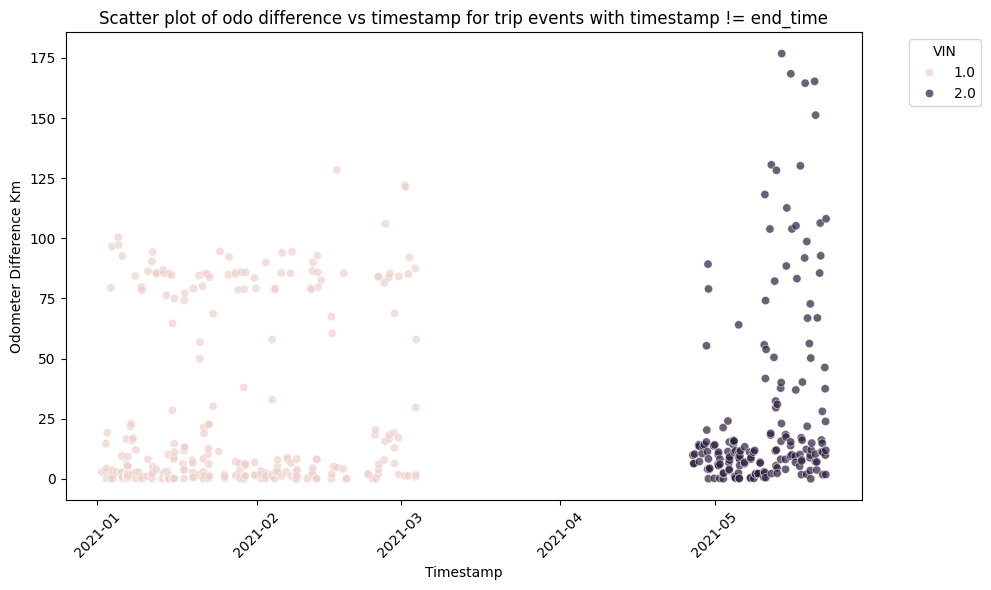

In [1442]:

filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()


filtered_data['odo_diff'] = filtered_data['end_odo'] - filtered_data['odo']

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='odo_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of odo difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Odometer Difference Km')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Detect Anomalous Trip Events with SoC Increase

In [1443]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_soc'] > data['soc']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))

Number of anamalous rows: 6


vin           timestamp            end_time           odo       end_odo  \
21   1.0 2021-01-05 17:05:00 2021-01-05 17:12:00   4868.421875   4870.953125   
68   2.0 2021-05-02 16:53:00 2021-05-02 16:57:00   2609.656250   2611.796875   
88   2.0 2021-05-04 22:08:00 2021-05-04 22:12:00   2777.484375   2778.328125   
207  1.0 2021-01-08 11:13:00 2021-01-08 13:23:00   5201.687500   5201.765625   
236  1.0 2021-01-13 19:30:00 2021-01-13 20:46:00   5996.968750   5998.875000   
433  1.0 2021-02-12 13:53:00 2021-02-12 22:27:00  10063.062500  10063.093750   

      soc  end_soc event charge_mode  duration  avg_speed  
21   58.4     58.8  trip           0       7.0  21.696429  
68   33.3     33.7  trip           0       4.0  32.109375  
88   24.3     24.7  trip           0       4.0  12.656250  
207  40.0     40.3  trip           0     130.0   0.036058  
236  50.1     50.9  trip           0      76.0   1.504934  
433  78.8     79.2  trip           0     514.0   0.003648

Minimum Diff SoC:  -0.7999999999999972


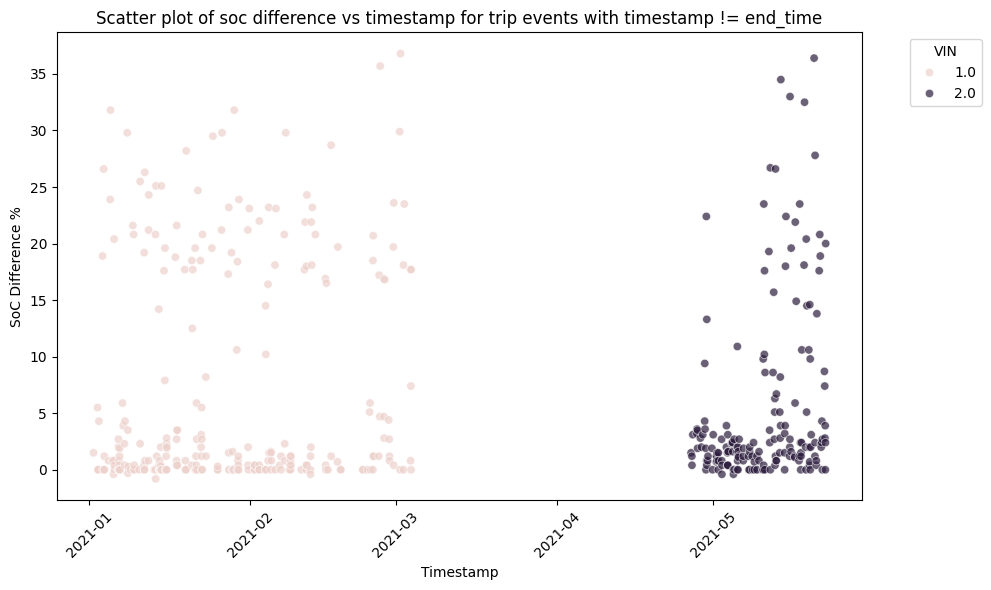

In [1444]:

filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()
filtered_data['soc_diff'] = filtered_data['soc'] - filtered_data['end_soc']

print("Minimum Diff SoC: ",filtered_data['soc_diff'].min())
# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('SoC Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Removed if it doesn't respect the bound 

In [1445]:
#if it increase more than 1% delete the row from data 
inital_length = len(data)
data = data[~((data['event'] == 'trip') & ((data['end_soc'] - data['soc']) > 1))].reset_index(drop=True)
final_length = len(data)
print(f"Number of rows removed: {inital_length - final_length}")


Number of rows removed: 0


### Detecting and removing Anomalous Trip Events with Odo Decrease

In [1446]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_odo'] < data['odo']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))


Number of anamalous rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode, duration, avg_speed]
Index: []

In [1447]:
data = data[~((data['event'] == 'trip') & (data['end_odo'] < data['odo']))].reset_index(drop=True)

### Identify Charge Events with No Charge Despite Time Elapsed

In [1448]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['soc'] == data['end_soc'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 10


vin           timestamp            end_time           odo       end_odo  \
19   1.0 2021-01-05 11:57:00 2021-01-05 11:59:00   4868.421875   4868.421875   
131  2.0 2021-05-10 17:54:00 2021-05-10 18:29:00   3083.781250   3083.781250   
157  2.0 2021-05-13 00:13:00 2021-05-13 00:21:00   3869.421875   3869.421875   
265  1.0 2021-01-15 20:04:00 2021-01-15 21:09:00   6454.234375   6454.234375   
426  1.0 2021-02-12 14:30:00 2021-02-12 15:44:00   9793.375000   9793.375000   
484  2.0 2021-05-19 14:25:00 2021-05-19 14:29:00   5928.312500   5928.312500   
488  2.0 2021-05-19 18:16:00 2021-05-19 18:33:00   6051.250000   6051.250000   
512  2.0 2021-05-21 22:17:00 2021-05-21 22:35:00   6816.406250   6816.406250   
519  2.0 2021-05-22 11:27:00 2021-05-22 11:38:00   6903.546875   6903.546875   
559  1.0 2021-02-25 17:56:00 2021-02-25 18:46:00  10730.671880  10730.671880   

      soc  end_soc   event charge_mode  duration  avg_speed  
19   16.0     16.0  charge         240       2.0        0.0  
131  76.0     76.0  charge         120      35.0        0.0  
157  30.1     30.1  charge         120       8.0        0.0  
265  51.3     51.3  charge         240      65.0        0.0  
426  98.8     98.8  charge         240      74.0        0.0  
484  79.6     79.6  charge         240       4.0        0.0  
488  54.9     54.9  charge         120      17.0        0.0  
512  36.0     36.0  charge           0      18.0        0.0  
519  75.6     75.6  charge         120      11.0        0.0  
559  92.1     92.1  charge           0      50.0        0.0

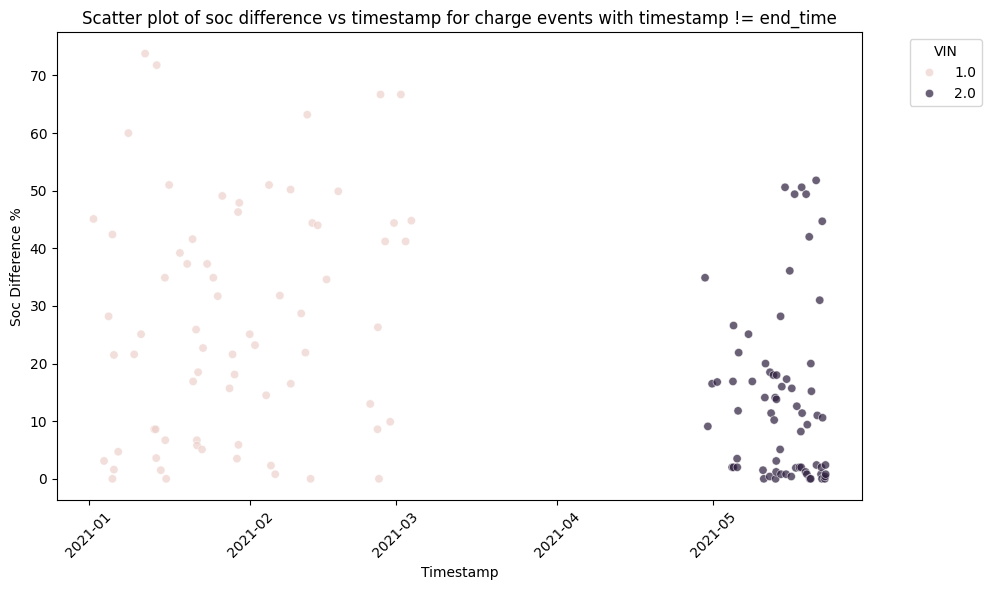

In [1449]:

filtered_data = data[(data['event'] == 'charge') & (data['timestamp'] != data['end_time'])].copy()


filtered_data['soc_diff'] = filtered_data['end_soc'] - filtered_data['soc']


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for charge events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Soc Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Cleaning

In [1450]:
length_before = len(data)
data = data[~((data['event'] == 'charge') & 
              (data['soc'] == data['end_soc']) & 
              (data['timestamp'] != data['end_time']))].reset_index(drop=True)
length_after = len(data)
print(f"Number of rows removed: {length_before - length_after}")


Number of rows removed: 10


### Detecting and removing Anomalous Charge Events with SoC Decrease

In [1451]:
anomalows_rows_charge = data[(data['event'] == 'charge') & (data['end_soc'] < data['soc']) ]
print(f"Number of anamalous rows: {anomalows_rows_charge.shape[0]}")
anomalows_rows_charge.head(len(anomalows_rows_charge))
data = data[~((data['event'] == 'charge') & (data['end_soc'] < data['soc']))].reset_index(drop=True)

Number of anamalous rows: 0


### Anomalies in Speed

In [1452]:
speed_trip = data[data['event'] == 'trip']
print("📊 Statistics on driven km:\n", speed_trip['avg_speed'].describe())
p99_speed = speed_trip['avg_speed'].quantile(0.99)
print(f"99th percentile of average speed: {p99_speed:.2f} km/h")


📊 Statistics on driven km:
 count    453.000000
mean      35.351566
std       39.026565
min        0.000000
25%       17.343750
50%       30.691964
75%       45.937500
max      672.991071
Name: avg_speed, dtype: float64
99th percentile of average speed: 98.07 km/h


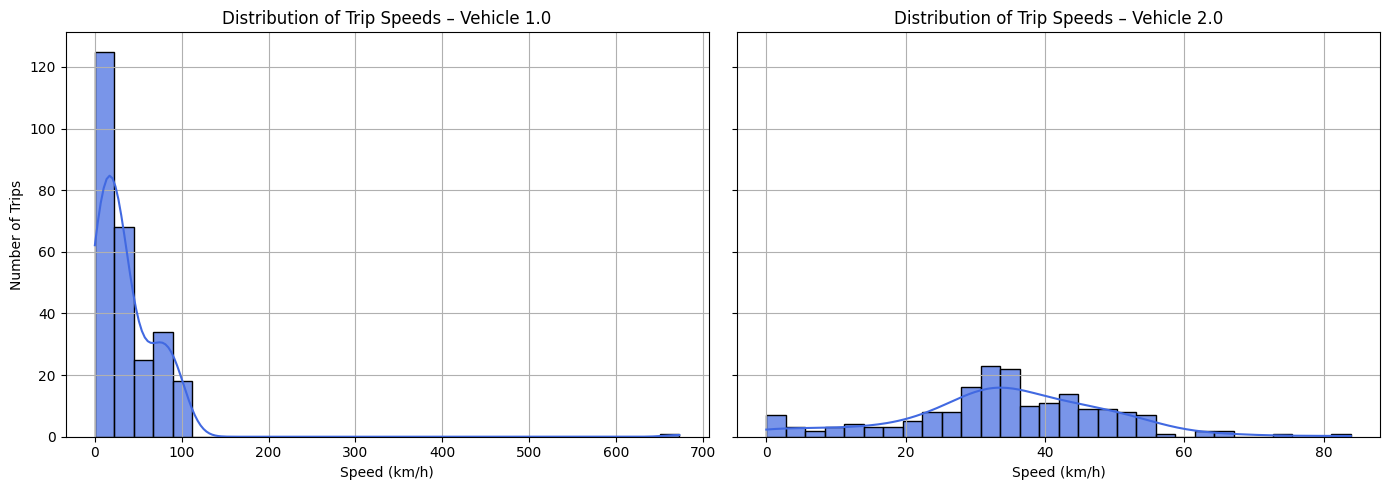

In [1453]:
vehicles = speed_trip['vin'].dropna().unique()[:2]  
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, vin in enumerate(vehicles):
    subset = speed_trip[speed_trip['vin'] == vin]

    sns.histplot(
        data=subset,
        x='avg_speed',
        bins=30,
        kde=True,
        color='royalblue',
        edgecolor='black',
        alpha=0.7,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of Trip Speeds – Vehicle {vin}')
    axes[i].set_xlabel('Speed (km/h)')
    axes[i].set_ylabel('Number of Trips')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [1454]:
print("maximum speed: ", data['avg_speed'].max())
max_speed_row = data[(data['avg_speed'] > 300)]

print("\n Row with maximum speed:\n")
max_speed_row.head(len(max_speed_row))



maximum speed:  672.9910714285714

 Row with maximum speed:



vin           timestamp            end_time       odo      end_odo   soc  \
212  1.0 2021-01-09 16:09:00 2021-01-09 16:16:00  5366.875  5445.390625  56.8   

     end_soc event charge_mode  duration   avg_speed  
212     56.4  trip           0       7.0  672.991071

In [1455]:
data = data.drop(max_speed_row.index).reset_index(drop=True)

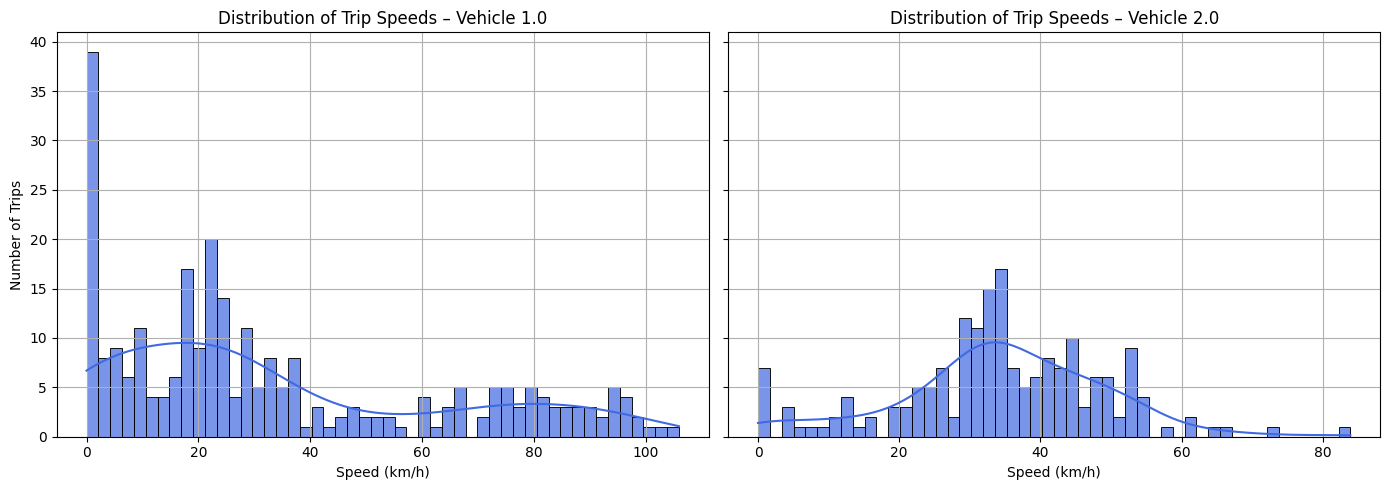

In [1456]:
speed_trip = data[data['event'] == 'trip']
vehicles = speed_trip['vin'].dropna().unique()[:2]  
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, vin in enumerate(vehicles):
    subset = speed_trip[speed_trip['vin'] == vin]

    sns.histplot(
        data=subset,
        x='avg_speed',
        bins=50,
        kde=True,
        color='royalblue',
        edgecolor='black',
        alpha=0.7,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of Trip Speeds – Vehicle {vin}')
    axes[i].set_xlabel('Speed (km/h)')
    axes[i].set_ylabel('Number of Trips')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Discharge Analysis

In [1457]:

trip_data = data[data['event'] == 'trip'].copy().reset_index(drop=True)
trip_data['km_driven'] = trip_data['end_odo'] - trip_data['odo']
trip_data['discharge'] = trip_data['soc'] - trip_data['end_soc']
print("📊 Statistics on driven km:\n", trip_data['km_driven'].describe())
print("\n🔋 Statistics on discharge:\n", trip_data['discharge'].describe())


📊 Statistics on driven km:
 count    452.000000
mean      27.481782
std       37.502814
min        0.000000
25%        1.949219
50%        8.531250
75%       40.593750
max      176.796875
Name: km_driven, dtype: float64

🔋 Statistics on discharge:
 count    452.000000
mean       6.252434
std        9.091085
min       -0.800000
25%        0.000000
50%        1.500000
75%        8.875000
max       36.800000
Name: discharge, dtype: float64


### Trip Efficiency Analysis: Battery Consumption per Distance and Distance per Battery Unit 

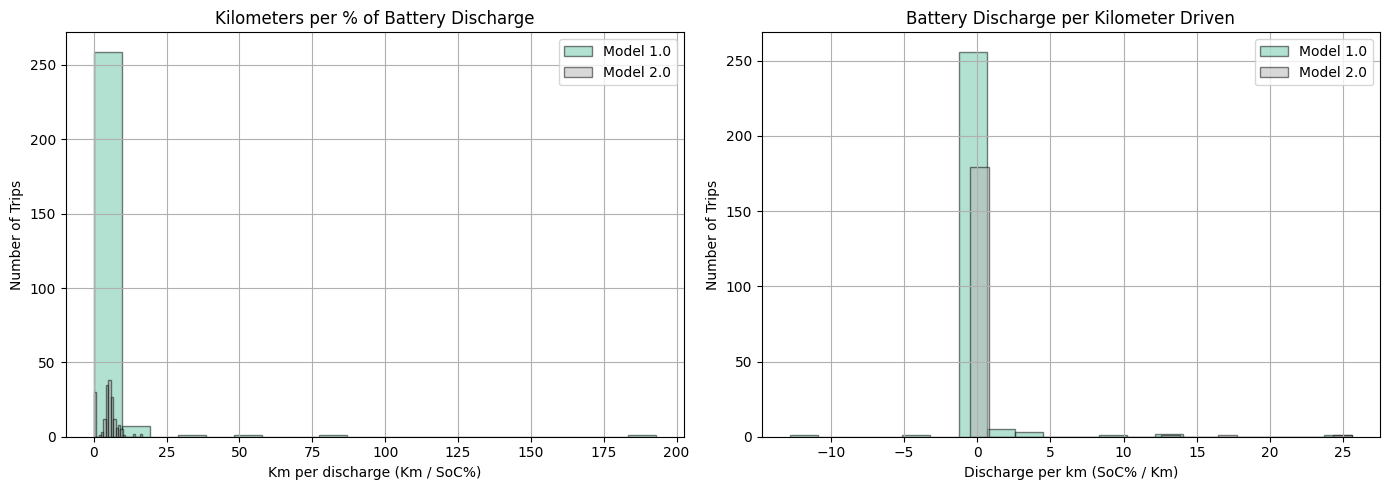

In [1458]:

trip_data['km_per_perc_of_battery'] = trip_data.apply(
    lambda row: row['km_driven'] / row['discharge'] if row['discharge'] > 0 else 0,
    axis=1
)

trip_data['discharge_per_km'] = trip_data.apply(
    lambda row: row['discharge'] / row['km_driven'] if row['km_driven'] > 0 else 0,
    axis=1
)

# Setup
models = trip_data['vin'].dropna().unique()
colors = plt.get_cmap('Set2', len(models))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[0].hist(
        subset['km_per_perc_of_battery'],
        bins=20,
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[0].set_title('Kilometers per % of Battery Discharge')
axes[0].set_xlabel('Km per discharge (Km / SoC%)')
axes[0].set_ylabel('Number of Trips')
axes[0].grid(True)
axes[0].legend()

for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[1].hist(
        subset['discharge_per_km'],
        bins=20,
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[1].set_title('Battery Discharge per Kilometer Driven')
axes[1].set_xlabel('Discharge per km (SoC% / Km)')
axes[1].set_ylabel('Number of Trips')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [1459]:
max_km = trip_data['km_driven'].max()
max_km_row = trip_data[trip_data['km_driven'] == max_km]

print("\n Row with maximum Km driven:\n")
max_km_row.head()


 Row with maximum Km driven:



vin           timestamp            end_time          odo     end_odo  \
136  2.0 2021-05-14 00:58:00 2021-05-14 04:54:00  4160.046875  4336.84375   

      soc  end_soc event charge_mode  duration  avg_speed   km_driven  \
136  43.9      9.4  trip           0     236.0  44.948358  176.796875   

     discharge  km_per_perc_of_battery  discharge_per_km  
136       34.5                5.124547          0.195139

### Analysis in Driven Km and SoC Discharge

#### Distribution of Trip Distance and Battery Discharge per Vehicle

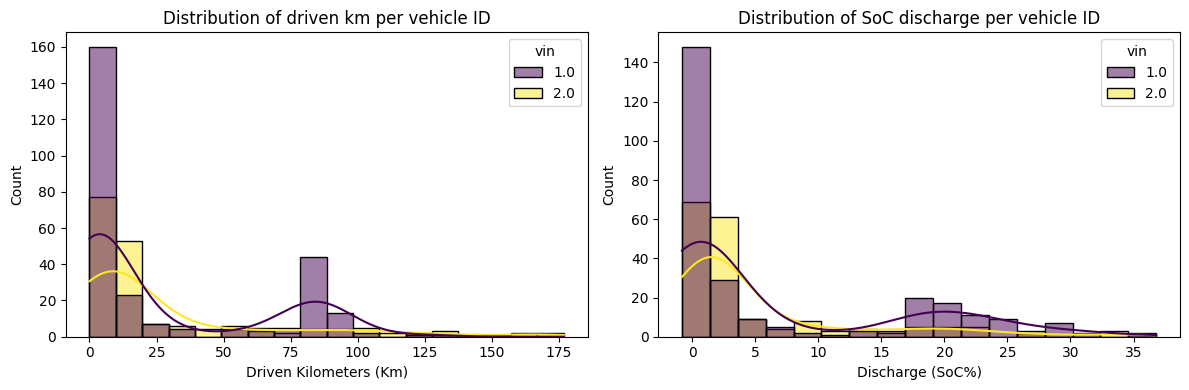

In [1460]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=trip_data, x='km_driven', kde=True, hue='vin', palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of driven km per vehicle ID')
axes[0].set_xlabel('Driven Kilometers (Km)')

sns.histplot(data=trip_data, x='discharge', kde=True, hue='vin', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of SoC discharge per vehicle ID')
axes[1].set_xlabel('Discharge (SoC%)')

plt.tight_layout()
plt.show()

#### 3D Density Surface of Kilometers Driven vs SoC Discharge per Vehicle

In [1461]:

vehicles = trip_data['vin'].unique()
colors = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Viridis'] 

fig = go.Figure()

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xedges = np.linspace(x.min(), x.max(), 31)
yedges = np.linspace(y.min(), y.max(), 31)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters, indexing="ij")

for i, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(
        subset['km_driven'], subset['discharge'],
        bins=[xedges, yedges],
        density=True
    )
    
    # Surface plot
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=hist,
        colorscale=colors[i % len(colors)],
        showscale=False,
        name=f'Vehicle {vin}',
        opacity=0.8,
        hoverinfo="skip", 
        legendgroup=f'{vin}', 
        showlegend=True  
    ))

    

fig.update_layout(
    title='3D Histogram Surface of driven km and discharge by each Vehicle',
    scene=dict(
        xaxis_title='Driven Kilometers',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(title="Vehicles")
)

fig.show()

In [1462]:


vehicles = trip_data['vin'].unique()
colors = ['Viridis', 'Cividis', 'Plasma', 'Inferno', 'Magma', 'Turbo']


cols = 2
rows = int(np.ceil(len(vehicles) / cols))

fig = make_subplots(
    rows=rows, 
    cols=cols, 
    specs=[[{'type': 'surface'}]*cols for _ in range(rows)],
    subplot_titles=[f'Vehicle {vin}' for vin in vehicles]
)

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for idx, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    xy_subset = np.vstack([subset['km_driven'].values, subset['discharge'].values])
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)

    row = idx // cols + 1
    col = idx % cols + 1

    fig.add_trace(
        go.Surface(
            x=X,
            y=Y,
            z=Z,
            colorscale=colors[idx % len(colors)],
            showscale=False,
            opacity=0.8
        ),
        row=row, 
        col=col
    )

fig.update_layout(
    title='3D KDE Surface of driven Km and discharge by Vehicle',
    height=400 * rows,
    width=700 * cols,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

#### 3D Histogram of Driven Kilometers and Battery Discharge

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



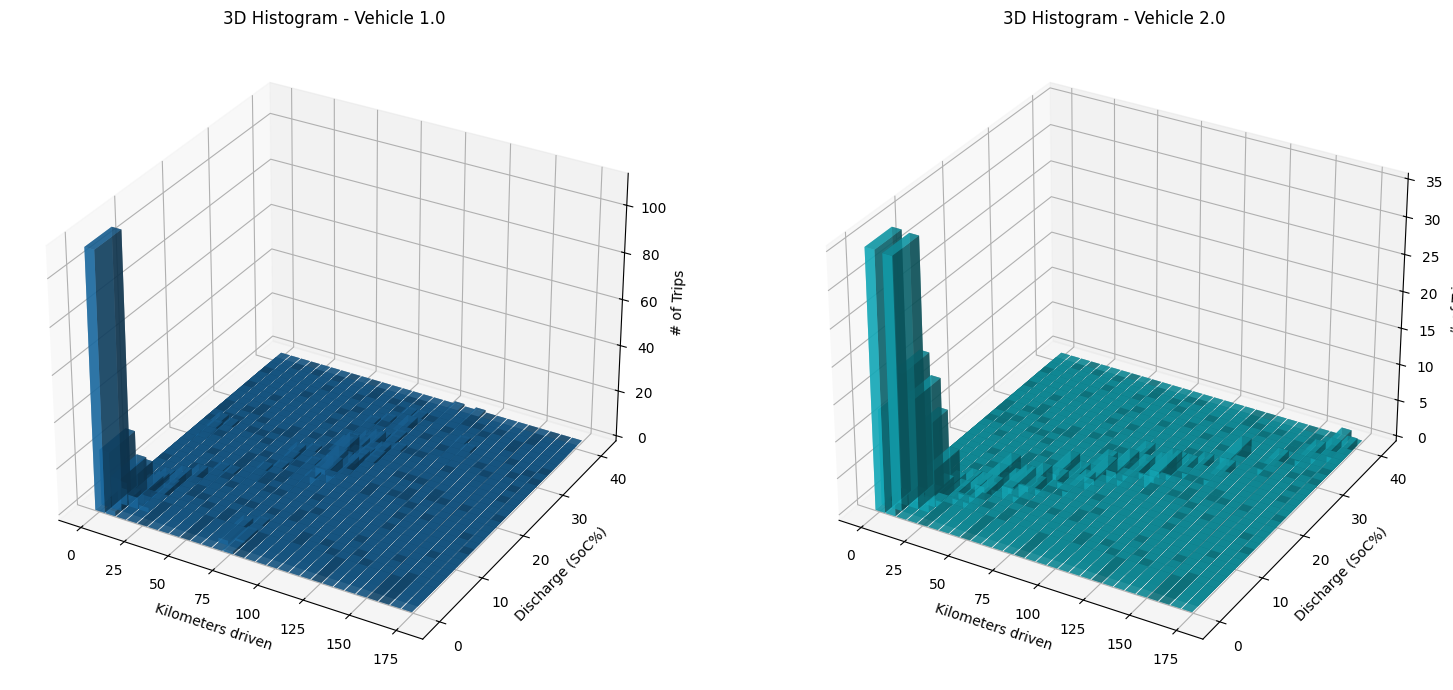

In [1463]:

vehicles = trip_data['vin'].unique()[:2]  
colors = plt.get_cmap('tab10', len(vehicles))

fig, axes = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': '3d'})  # 1 riga, 2 colonne

xedges = np.linspace(trip_data['km_driven'].min(), trip_data['km_driven'].max(), 30)
yedges = np.linspace(trip_data['discharge'].min(), trip_data['discharge'].max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for idx, (ax, vin) in enumerate(zip(axes, vehicles)):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(subset['km_driven'], subset['discharge'], bins=[xedges, yedges], density=False)

    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors(idx), alpha=0.7, shade=True)
    ax.set_title(f'3D Histogram - Vehicle {vin}')
    ax.set_xlabel('Kilometers driven')
    ax.set_ylabel('Discharge (SoC%)')
    ax.set_zlabel('# of Trips')

plt.tight_layout()
plt.show()

#### Scatter Plot of Battery Discharge vs Kilometers Driven by Vehicle

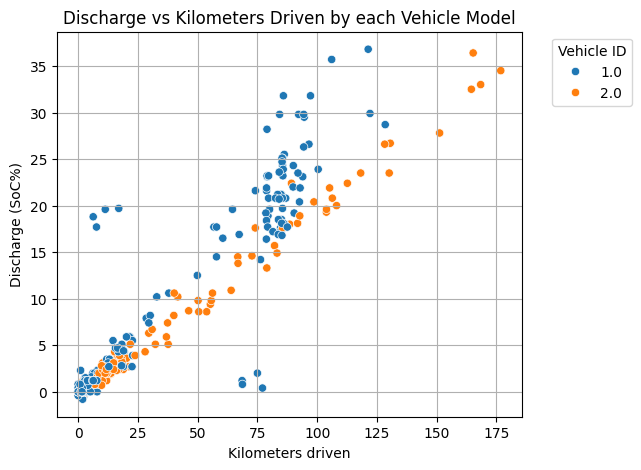

In [1464]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=trip_data, x='km_driven', y='discharge',hue = 'vin', palette = 'tab10')
plt.title('Discharge vs Kilometers Driven by each Vehicle Model')
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Kilometers driven')
plt.ylabel('Discharge (SoC%)')
plt.grid(True)
plt.show()



fig = px.scatter(
    trip_data,
    x='km_driven',
    y='discharge',
    color='vin',
    hover_data={
        'vin': True,
        'km_driven': True,
        'discharge': True,
        'custom_index': trip_data.index,
        'avg_speed': True,
        'duration': True
    },
    title='Discharge vs Kilometers Driven by each Vehicle Model',
    labels={
        'km_driven': 'Kilometers Driven',
        'discharge': 'Discharge (SoC%)',
        'vin': 'Vehicle ID',
        'custom_index': 'Row Index',
        'avg_speed': 'Average Speed (km/h)',
        'duration': 'Duration (minutes)'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()

In [1465]:

trip_data.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
2  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
3  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   
4  1.0 2021-01-02 18:18:00 2021-01-02 18:19:00  4461.450000  4461.48375   

     soc  end_soc event charge_mode  duration  avg_speed  km_driven  \
0   56.4     54.9  trip           0       7.0  24.241071   2.828125   
1  100.0    100.0  trip           0       8.0  22.734375   3.031250   
2  100.0     94.5  trip           0     145.0   6.051724  14.625000   
3   94.5     94.5  trip           0       7.0  37.071429   4.325000   
4   94.1     94.1  trip           0       1.0   2.025000   0.033750   

   discharge  km_per_perc_of_battery  discharge_per_km  
0        1.5                1.885417          0.530387  
1        0.0                0.000000          0.000000  
2        5.5                2.659091          0.376068  
3        0.0                0.000000          0.000000  
4        0.0                0.000000          0.000000

In [1466]:
# Mahalanobis distance for anomaly detection
xy = trip_data[['km_driven', 'discharge']].to_numpy()
cov = np.cov(xy, rowvar=False)
inv_cov = np.linalg.inv(cov)
mean = xy.mean(axis=0)

dists = np.array([ (x-mean).T @ inv_cov @ (x-mean) for x in xy ])
trip_data['mah_dist'] = dists
threshold = stats.chi2.ppf(0.99, df=2)  # 99° perc.
anomalies = trip_data[dists > threshold]
print(f"Number of anomalies detected: {len(anomalies)}")
print("\nAnomalies detected:")
anomalies.head(len(anomalies))

Number of anomalies detected: 23

Anomalies detected:


vin           timestamp            end_time           odo       end_odo  \
14   1.0 2021-01-05 03:00:00 2021-01-05 04:01:00   4768.390625   4865.609375   
136  2.0 2021-05-14 00:58:00 2021-05-14 04:54:00   4160.046875   4336.843750   
162  1.0 2021-01-08 08:04:00 2021-01-08 08:57:00   5105.359375   5189.656250   
214  1.0 2021-01-15 23:00:00 2021-01-16 09:39:00   6488.343750   6563.365008   
215  1.0 2021-01-17 14:20:00 2021-01-17 15:14:00   6563.365008   6569.703125   
223  1.0 2021-01-17 23:12:00 2021-01-18 11:19:00   6689.750000   6766.881646   
224  1.0 2021-01-19 09:46:00 2021-01-19 10:59:00   6766.881646   6774.593750   
229  1.0 2021-01-19 16:27:00 2021-01-19 17:29:00   6785.125000   6864.156250   
253  1.0 2021-01-23 11:41:00 2021-01-23 17:03:00   7551.140625   7619.759321   
254  1.0 2021-01-24 14:29:00 2021-01-24 15:23:00   7619.759321   7631.140625   
255  1.0 2021-01-24 19:28:00 2021-01-24 20:56:00   7631.140625   7725.734375   
260  1.0 2021-01-26 13:39:00 2021-01-26 14:52:00   7813.734375   7905.984375   
272  1.0 2021-01-28 22:05:00 2021-01-28 22:56:00   8176.765625   8262.656250   
318  1.0 2021-02-07 19:40:00 2021-02-07 21:00:00   9327.125000   9421.515625   
346  2.0 2021-05-15 19:24:00 2021-05-16 00:11:00   4624.343750   4792.734375   
357  2.0 2021-05-17 16:10:00 2021-05-17 19:51:00   5171.656250   5301.796875   
365  2.0 2021-05-18 14:24:00 2021-05-18 18:16:00   5484.109375   5648.609375   
380  2.0 2021-05-20 10:29:00 2021-05-20 14:14:00   6078.125000   6243.375000   
383  2.0 2021-05-20 15:07:00 2021-05-20 19:20:00   6260.734375   6411.953125   
429  1.0 2021-02-25 23:42:00 2021-02-26 01:09:00  10827.828130  10933.906250   
437  1.0 2021-02-27 18:29:00 2021-02-27 21:50:00  11175.984380  11244.728590   
438  1.0 2021-02-28 12:08:00 2021-02-28 12:58:00  11244.728590  11261.765630   
443  1.0 2021-03-01 21:38:00 2021-03-01 22:55:00  11471.031250  11592.375000   

       soc  end_soc event charge_mode  duration   avg_speed   km_driven  \
14    48.2     16.4  trip           0      61.0   95.625000   97.218750   
136   43.9      9.4  trip           0     236.0   44.948358  176.796875   
162   74.1     44.3  trip           0      53.0   95.430425   84.296875   
214   43.5     41.5  trip           0     639.0    7.044250   75.021258   
215   92.5     73.7  trip           0      54.0    7.042352    6.338117   
223   39.2     38.8  trip           0     727.0    6.365748   77.131646   
224   78.0     60.3  trip           0      73.0    6.338716    7.712104   
229   58.0     29.8  trip           0      62.0   76.481855   79.031250   
253   42.7     41.5  trip           0     322.0   12.786092   68.618696   
254   78.8     59.2  trip           0      54.0   12.645893   11.381304   
255   60.0     30.5  trip           0      88.0   64.495739   94.593750   
260   75.2     45.4  trip           0      73.0   75.821918   92.250000   
272   67.8     36.0  trip           0      51.0  101.047794   85.890625   
318   38.4      8.6  trip           0      80.0   70.792969   94.390625   
346   74.9     41.9  trip           0     287.0   35.203615  168.390625   
357   52.9     29.4  trip           0     221.0   35.332296  130.140625   
365   65.4     32.9  trip           0     232.0   42.543103  164.500000   
380   85.0     48.6  trip           0     225.0   44.066667  165.250000   
383   45.0     17.2  trip           0     253.0   35.862154  151.218750   
429   69.0     33.3  trip           0      87.0   73.157324  106.078120   
437   90.9     90.1  trip           0     201.0   20.520660   68.744210   
438  100.0     80.3  trip           0      50.0   20.444448   17.037040   
443   70.1     33.3  trip           0      77.0   94.553571  121.343750   

     discharge  km_per_perc_of_battery  discharge_per_km   mah_dist  
14        31.8                3.057193          0.327097  13.548563  
136       34.5                5.124547          0.195139  19.642987  
162       29.8                2.828754          0.353513  14.490071  
214

In [1467]:
# Isolation Forest for anomaly detection
clf = IsolationForest(contamination=0.05, random_state=42)
trip_data['anomaly_if'] = clf.fit_predict(trip_data[['km_driven', 'discharge']])
anomalies = trip_data[trip_data['anomaly_if'] == -1]
print(f"Number of anomalies detected with Isolation Forest: {len(anomalies)}")
print("\nAnomalies detected with Isolation Forest:")
anomalies.head(len(anomalies))

Number of anomalies detected with Isolation Forest: 23

Anomalies detected with Isolation Forest:


vin           timestamp            end_time           odo       end_odo  \
14   1.0 2021-01-05 03:00:00 2021-01-05 04:01:00   4768.390625   4865.609375   
109  2.0 2021-05-10 18:29:00 2021-05-10 20:42:00   3083.781250   3202.000000   
118  2.0 2021-05-12 00:37:00 2021-05-12 03:30:00   3515.250000   3645.812500   
126  2.0 2021-05-13 00:21:00 2021-05-13 02:48:00   3869.421875   3997.687500   
136  2.0 2021-05-14 00:58:00 2021-05-14 04:54:00   4160.046875   4336.843750   
214  1.0 2021-01-15 23:00:00 2021-01-16 09:39:00   6488.343750   6563.365008   
215  1.0 2021-01-17 14:20:00 2021-01-17 15:14:00   6563.365008   6569.703125   
223  1.0 2021-01-17 23:12:00 2021-01-18 11:19:00   6689.750000   6766.881646   
224  1.0 2021-01-19 09:46:00 2021-01-19 10:59:00   6766.881646   6774.593750   
253  1.0 2021-01-23 11:41:00 2021-01-23 17:03:00   7551.140625   7619.759321   
254  1.0 2021-01-24 14:29:00 2021-01-24 15:23:00   7619.759321   7631.140625   
272  1.0 2021-01-28 22:05:00 2021-01-28 22:56:00   8176.765625   8262.656250   
346  2.0 2021-05-15 19:24:00 2021-05-16 00:11:00   4624.343750   4792.734375   
357  2.0 2021-05-17 16:10:00 2021-05-17 19:51:00   5171.656250   5301.796875   
365  2.0 2021-05-18 14:24:00 2021-05-18 18:16:00   5484.109375   5648.609375   
380  2.0 2021-05-20 10:29:00 2021-05-20 14:14:00   6078.125000   6243.375000   
383  2.0 2021-05-20 15:07:00 2021-05-20 19:20:00   6260.734375   6411.953125   
409  1.0 2021-02-16 13:23:00 2021-02-17 18:51:00  10282.578130  10411.046880   
429  1.0 2021-02-25 23:42:00 2021-02-26 01:09:00  10827.828130  10933.906250   
437  1.0 2021-02-27 18:29:00 2021-02-27 21:50:00  11175.984380  11244.728590   
438  1.0 2021-02-28 12:08:00 2021-02-28 12:58:00  11244.728590  11261.765630   
441  1.0 2021-03-01 17:38:00 2021-03-01 19:15:00  11347.671880  11469.781250   
443  1.0 2021-03-01 21:38:00 2021-03-01 22:55:00  11471.031250  11592.375000   

       soc  end_soc event charge_mode  duration   avg_speed   km_driven  \
14    48.2     16.4  trip           0      61.0   95.625000   97.218750   
109   76.0     52.5  trip           0     133.0   53.331767  118.218750   
118   43.5     16.8  trip           0     173.0   45.281792  130.562500   
126   30.1      3.5  trip           0     147.0   52.353316  128.265625   
136   43.9      9.4  trip           0     236.0   44.948358  176.796875   
214   43.5     41.5  trip           0     639.0    7.044250   75.021258   
215   92.5     73.7  trip           0      54.0    7.042352    6.338117   
223   39.2     38.8  trip           0     727.0    6.365748   77.131646   
224   78.0     60.3  trip           0      73.0    6.338716    7.712104   
253   42.7     41.5  trip           0     322.0   12.786092   68.618696   
254   78.8     59.2  trip           0      54.0   12.645893   11.381304   
272   67.8     36.0  trip           0      51.0  101.047794   85.890625   
346   74.9     41.9  trip           0     287.0   35.203615  168.390625   
357   52.9     29.4  trip           0     221.0   35.332296  130.140625   
365   65.4     32.9  trip           0     232.0   42.543103  164.500000   
380   85.0     48.6  trip           0     225.0   44.066667  165.250000   
383   45.0     17.2  trip           0     253.0   35.862154  151.218750   
409   98.8     70.1  trip           0    1768.0    4.359799  128.468750   
429   69.0     33.3  trip           0      87.0   73.157324  106.078120   
437   90.9     90.1  trip           0     201.0   20.520660   68.744210   
438  100.0     80.3  trip           0      50.0   20.444448   17.037040   
441  100.0     70.1  trip           0      97.0   75.531569  122.109370   
443   70.1     33.3  trip           0      77.0   94.553571  121.343750   

     discharge  km_per_perc_of_battery  discharge_per_km   mah_dist  \
14        31.8                3.057193          0.327097  13.548563   
109       23.5                5.030585          0.198784   7.190514   
118       26.7                4.889981          0.204500   8.618043   

#### Visualize battery discharge across driven distance for each trip

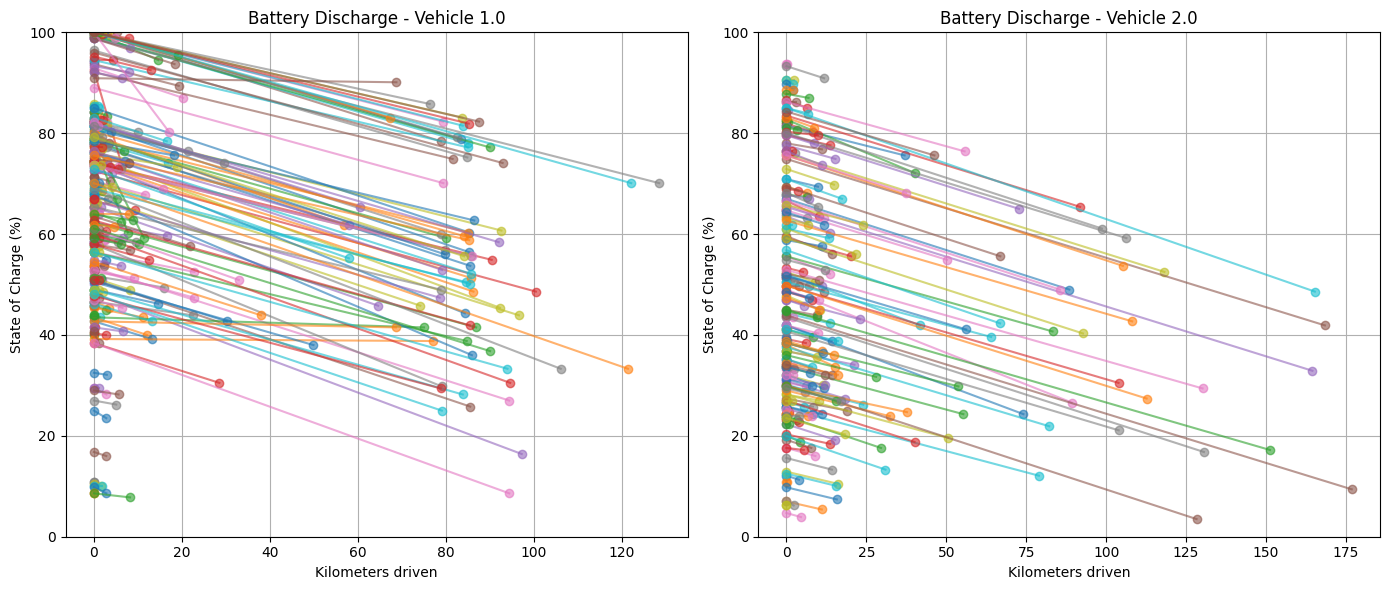

In [1468]:


vehicles = trip_data['vin'].unique()[:2]  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

for idx, vin in enumerate(vehicles):
    ax = axes[idx]
    subset = trip_data[trip_data['vin'] == vin]

    for _, row in subset.iterrows():
        x_vals = [0, row['km_driven']]
        y_vals = [row['soc'], row['end_soc']]
        ax.plot(x_vals, y_vals, marker='o', alpha=0.6)

    ax.set_title(f'Battery Discharge - Vehicle {vin}')
    ax.set_xlabel('Kilometers driven')
    ax.set_ylabel('State of Charge (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Charge Analysis

In [1469]:
charge_data = data[data['event'] == 'charge'].copy().reset_index(drop=True)
charge_data['diff_battery'] = charge_data['end_soc'] - charge_data['soc']
charge_data['charge_mode'] = charge_data['charge_mode'].cat.remove_unused_categories()
print("🔋 Statistics on charge km:\n", charge_data['diff_battery'].describe())
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔋 Statistics on charge km:
 count    129.000000
mean      22.214729
std       18.793367
min        0.400000
25%        5.800000
50%       16.900000
75%       36.100000
max       73.800000
Name: diff_battery, dtype: float64

🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


In [1470]:
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


### Battery Charge Rate per Vehicle: Distribution of %/min by Charge Mode

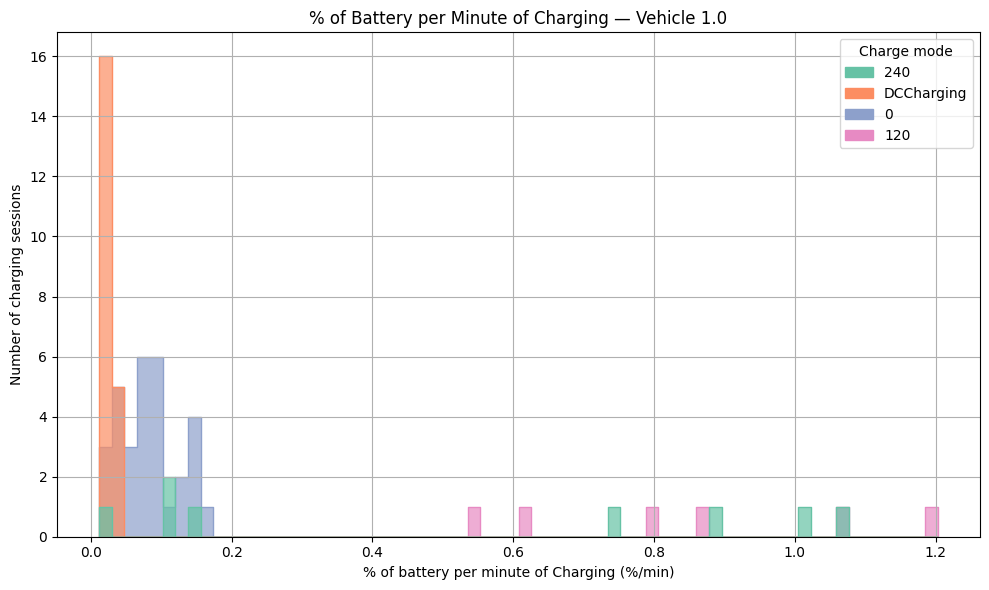

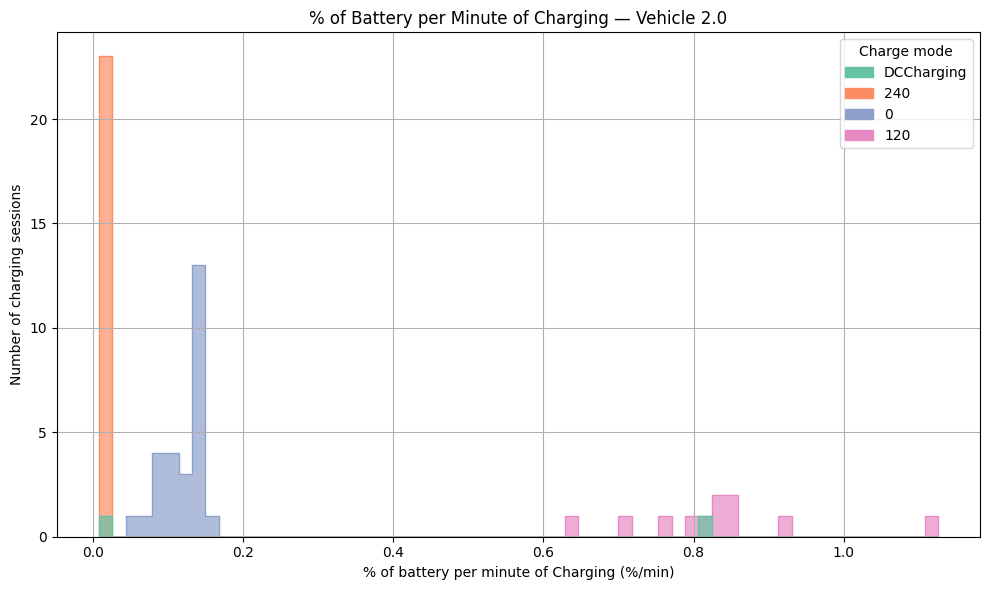

In [1471]:
#TODO: Verify this plot


charge_data['perc_per_min'] = charge_data.apply(
    lambda row: row['diff_battery'] / row['duration'] if row['duration'] > 0 else 0,
    axis=1
)

vehicles = charge_data['vin'].dropna().unique()

for vin in vehicles:
    subset = charge_data[charge_data['vin'] == vin]

    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=subset,
        x='perc_per_min',
        bins=len(subset),
        hue='charge_mode',
        palette='Set2',
        element='step',
        stat='count',
        alpha=0.7
    )
    handles = []
    palette = sns.color_palette('Set2')
    modes = subset['charge_mode'].dropna().unique()

    for i, mode in enumerate(modes):
        color = palette[i % len(palette)]
        patch = mpatches.Patch(color=color, label=mode)
        handles.append(patch)

    plt.title(f'% of Battery per Minute of Charging — Vehicle {vin}')
    plt.xlabel('% of battery per minute of Charging (%/min)')
    plt.ylabel('Number of charging sessions')
    plt.grid(True)
    plt.legend(handles=handles,title='Charge mode')
    plt.tight_layout()
    plt.show()

### Analysis of Vehicle Charging Rates and Density Patterns

#### 3D KDE Surface Plots of Charging Duration vs Battery State Change for Multiple Vehicles

In [1472]:
vehicles = charge_data['vin'].dropna().unique()[:2]
color_sets = [
    pc.sequential.Viridis,
    pc.sequential.Plasma,
    pc.sequential.Cividis,
    pc.sequential.Inferno,
    pc.sequential.Magma,
    pc.sequential.Turbo
]

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=[f"Vehicle {vin}" for vin in vehicles]
)

for col, vin in enumerate(vehicles, start=1):
    subset_vehicle = charge_data[charge_data['vin'] == vin]
    modes = subset_vehicle['charge_mode'].dropna().unique()

    x = subset_vehicle['duration'].dropna().values
    y = subset_vehicle['diff_battery'].dropna().values
    xgrid = np.linspace(x.min(), x.max(), 100)
    ygrid = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])

    for i, mode in enumerate(modes):
        subset = subset_vehicle[subset_vehicle['charge_mode'] == mode]
        if len(subset) < 2:
            continue
        xy_subset = np.vstack([subset['duration'].values, subset['diff_battery'].values])
        kde = gaussian_kde(xy_subset)
        Z = np.reshape(kde(positions).T, X.shape)

        fig.add_trace(
            go.Surface(
                x=X,
                y=Y,
                z=Z,
                colorscale=color_sets[i % len(color_sets)],
                name=f"{mode} — V{vin}",
                showscale=False,
                opacity=0.8,
                legendgroup=mode,
                showlegend=True,
            ),
            row=1, col=col
        )


fig.update_layout(
    title='3D KDE Surface of Charging Duration vs Battery Difference per Vehicle',
    scene=dict(
        xaxis_title='Duration (min)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    scene2=dict(
        xaxis_title='Duration (min)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    legend=dict(
        title="Charge Mode",
        itemsizing='constant',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1,
        x=0.85,
        y=0.95
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

#### 3D Histogram of Vehicle Charging Patterns by Mode

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



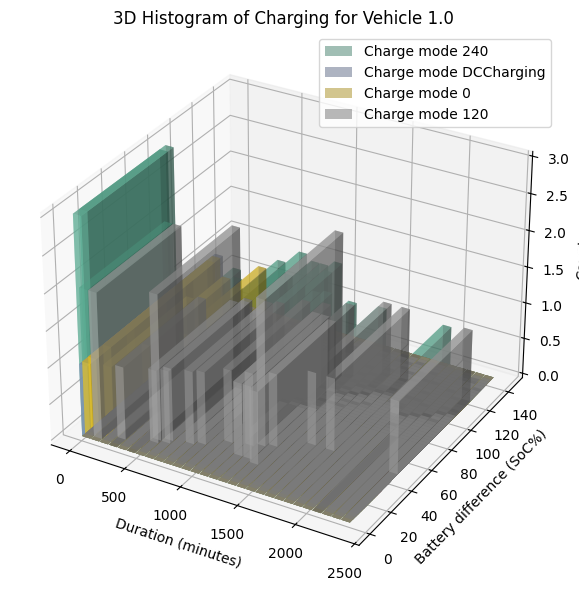

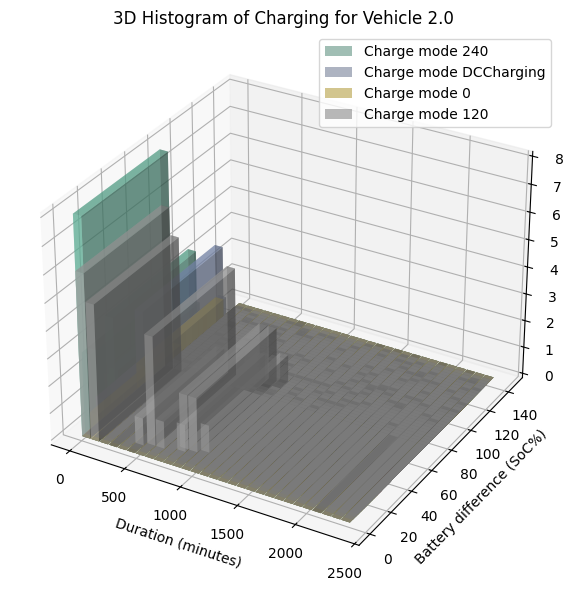

In [1473]:
vehicles = charge_data['vin'].dropna().unique()
charge_modes = charge_data['charge_mode'].dropna().unique()
colors = plt.get_cmap('Set2', len(charge_modes))  

x = charge_data['duration'].dropna()
y = charge_data['diff_battery'].dropna()
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for vin in vehicles:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, mode in enumerate(charge_modes):
        subset = charge_data[
            (charge_data['vin'] == vin) &
            (charge_data['charge_mode'] == mode)
        ]
        if subset.empty:
            continue

        hist, _, _ = np.histogram2d(
            subset['duration'].dropna(),
            subset['diff_battery'].dropna(),
            bins=[xedges, yedges],
            density=False
        )

        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = np.zeros_like(xpos)
        dz = hist.ravel()

        ax.bar3d(
            xpos, ypos, zpos,
            dx, dy, dz,
            color=colors(i),
            alpha=0.5,  
            label=f'Charge mode {mode}',
            shade=True
        )

    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Battery difference (SoC%)')
    ax.set_zlabel('Count')
    ax.set_title(f'3D Histogram of Charging for Vehicle {vin}')
    ax.legend()
    plt.tight_layout()
    plt.show()

#### Battery Charge Progression by Charge Mode per Vehicle

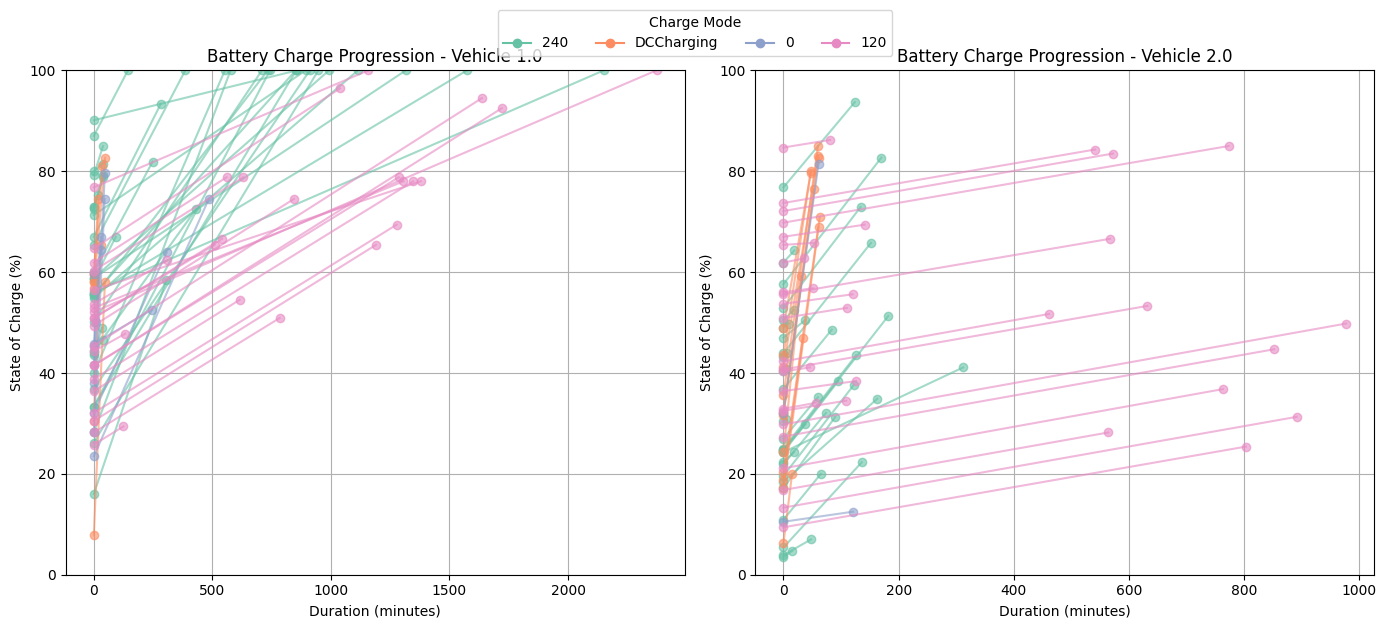

In [1474]:
from matplotlib.lines import Line2D
vehicles = charge_data['vin'].dropna().unique()[:2]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
charge_modes = charge_data['charge_mode'].dropna().unique()
palette = sns.color_palette('Set2', len(charge_modes))
mode_to_color = {mode: palette[i] for i, mode in enumerate(charge_modes)}

for idx, vin in enumerate(vehicles):
    ax = axes[idx]
    subset = charge_data[charge_data['vin'] == vin]

    for mode in charge_modes:
        mode_subset = subset[subset['charge_mode'] == mode]
        for _, row in mode_subset.iterrows():
            x_vals = [0, row['duration']]
            y_vals = [row['soc'], row['end_soc']]
            ax.plot(x_vals, y_vals, marker='o', alpha=0.6, color=mode_to_color[mode])

    ax.set_title(f'Battery Charge Progression - Vehicle {vin}')
    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('State of Charge (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)


handles = [Line2D([0], [0], color=mode_to_color[mode], label=mode, marker='o', linestyle='-') for mode in charge_modes]
fig.legend(handles=handles, title='Charge Mode', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(charge_modes))

plt.tight_layout()
plt.show()

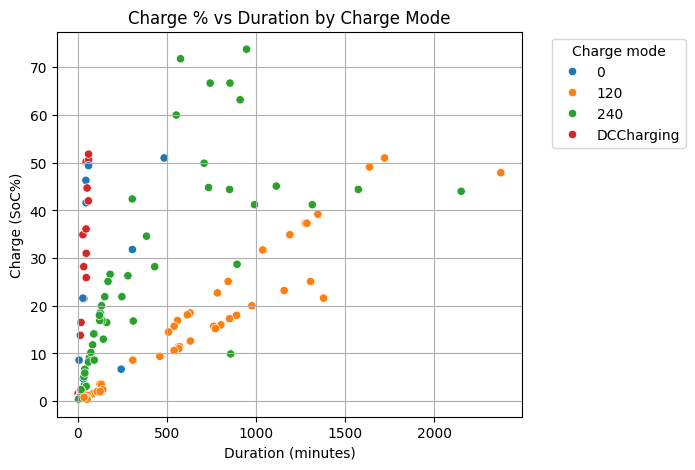

In [1475]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=charge_data, x='duration', y='diff_battery',hue = 'charge_mode', palette = 'tab10')
plt.title('Charge % vs Duration by Charge Mode')
plt.legend(title='Charge mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Duration (minutes)')
plt.ylabel('Charge (SoC%)')
plt.grid(True)
plt.show()

#### Charge_mode imputation

##### Angular Coefficient

In [1476]:
#print the medium angular coefficient (end_soc - soc) / duration for each charge mode for each vehicle

avg_coeffs = charge_data.groupby(['vin', 'charge_mode'])['perc_per_min'].mean().reset_index()
print("\nAverage angular coefficient (end_soc - soc) / duration for each charge mode for each vehicle:")
print(avg_coeffs)



Average angular coefficient (end_soc - soc) / duration for each charge mode for each vehicle:
   vin charge_mode  perc_per_min
0  1.0           0      0.511816
1  1.0         120      0.027142
2  1.0         240      0.081269
3  1.0  DCCharging      0.848971
4  2.0           0      0.413182
5  2.0         120      0.018621
6  2.0         240      0.120734
7  2.0  DCCharging      0.830703


/var/folders/yf/3whxpy_91xb0fnz553qstm580000gn/T/ipykernel_9646/1042236774.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##### Clustering

In [1477]:
#https://arxiv.org/abs/1907.09458
from sklearn.preprocessing import StandardScaler
features = ['perc_per_min', 'duration', 'diff_battery']
scaler = StandardScaler()
X = scaler.fit_transform(charge_data[features].dropna())
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
charge_data.loc[~charge_data[features].isna().any(axis=1), 'cluster'] = labels
mapping = {0: '240', 1: '120', 2: 'DCCharging'} 
charge_data['charge_mode_inferred'] = charge_data['cluster'].map(mapping)
#change only in charge_mode==0 with the inferred charge_mode
charge_data_inf =charge_data.copy()
charge_data_inf.loc[charge_data_inf['charge_mode'] == '0', 'charge_mode'] = charge_data_inf['charge_mode_inferred']


In [1478]:
charge_data.head()

vin           timestamp            end_time          odo      end_odo  \
0  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.468750   
1  1.0 2021-01-03 21:18:00 2021-01-03 21:56:00  4658.234375  4658.234375   
2  1.0 2021-01-04 18:16:00 2021-01-05 01:28:00  4667.953125  4667.953125   
3  1.0 2021-01-05 11:59:00 2021-01-05 17:05:00  4868.421875  4868.421875   
4  1.0 2021-01-05 18:52:00 2021-01-05 18:54:00  4880.484375  4880.484375   

    soc  end_soc   event charge_mode  duration  avg_speed  diff_battery  \
0  54.9    100.0  charge         240    1114.0        0.0          45.1   
1  43.5     46.6  charge         240      38.0        0.0           3.1   
2  44.3     72.5  charge         240     432.0        0.0          28.2   
3  16.0     58.4  charge         240     306.0        0.0          42.4   
4  58.0     59.6  charge  DCCharging       2.0        0.0           1.6   

   perc_per_min  cluster charge_mode_inferred  
0      0.040485      1.0                  120  
1      0.081579      0.0                  240  
2      0.065278      0.0                  240  
3      0.138562      1.0                  120  
4      0.800000      2.0           DCCharging

In [1479]:
charge_data_inf.head()

vin           timestamp            end_time          odo      end_odo  \
0  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.468750   
1  1.0 2021-01-03 21:18:00 2021-01-03 21:56:00  4658.234375  4658.234375   
2  1.0 2021-01-04 18:16:00 2021-01-05 01:28:00  4667.953125  4667.953125   
3  1.0 2021-01-05 11:59:00 2021-01-05 17:05:00  4868.421875  4868.421875   
4  1.0 2021-01-05 18:52:00 2021-01-05 18:54:00  4880.484375  4880.484375   

    soc  end_soc   event charge_mode  duration  avg_speed  diff_battery  \
0  54.9    100.0  charge         240    1114.0        0.0          45.1   
1  43.5     46.6  charge         240      38.0        0.0           3.1   
2  44.3     72.5  charge         240     432.0        0.0          28.2   
3  16.0     58.4  charge         240     306.0        0.0          42.4   
4  58.0     59.6  charge  DCCharging       2.0        0.0           1.6   

   perc_per_min  cluster charge_mode_inferred  
0      0.040485      1.0                  120  
1      0.081579      0.0                  240  
2      0.065278      0.0                  240  
3      0.138562      1.0                  120  
4      0.800000      2.0           DCCharging

In [1480]:
fig = px.scatter(
    charge_data,
    x='duration',
    y='diff_battery',
    color='charge_mode',
    hover_data={'vin' :True, 'charge_mode': True, 'duration': True, 'diff_battery': True, 'custom_index': charge_data.index, 'perc_per_min': True, 'cluster': True,'charge_mode_inferred': True },  
    title='Difference in battery vs duration of charge by each Vehicle Model (Original)',
    labels={ 'vin': 'Vehicle ID',
        'duration': 'Duration (minutes)',
        'diff_battery': 'Difference in Battery (SoC%)',
        'charge_mode': 'Charge Mode',
        'custom_index': 'Row Index',
        'perc_per_min': '% of Battery per Minute of Charging (%/min)',
        'cluster': 'Cluster',
        'charge_mode_inferred': 'Inferred Charge Mode'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()

In [1481]:
fig = px.scatter(
    charge_data_inf,
    x='duration',
    y='diff_battery',
    color='charge_mode',
    hover_data={'vin' :True, 'charge_mode': True, 'duration': True, 'diff_battery': True, 'custom_index': charge_data.index, 'perc_per_min': True, 'cluster': True,'charge_mode_inferred': True },  
    title='Difference in battery vs duration of charge by each Vehicle Model (Clustered only 0 mode)',
    labels={ 'vin': 'Vehicle ID',
        'duration': 'Duration (minutes)',
        'diff_battery': 'Difference in Battery (SoC%)',
        'charge_mode': 'Charge Mode',
        'custom_index': 'Row Index',
        'perc_per_min': '% of Battery per Minute of Charging (%/min)',
        'cluster': 'Cluster',
        'charge_mode_inferred': 'Inferred Charge Mode'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()


In [1508]:
charge_data_inf = charge_data_inf.reset_index() 

fig = px.scatter(
    charge_data_inf,
    x='duration',
    y='diff_battery',
    color='charge_mode_inferred',
    hover_data={'vin' :True, 'charge_mode': True, 'duration': True, 'diff_battery': True, 'custom_index': charge_data.index, 'perc_per_min': True, 'cluster': True,'charge_mode_inferred': True },  
    title='Difference in battery vs duration of charge by each Vehicle Model (Clustered all charge modes) (What k-means sees)',
    labels={ 'vin': 'Vehicle ID',
        'duration': 'Duration (minutes)',
        'diff_battery': 'Difference in Battery (SoC%)',
        'charge_mode': 'Charge Mode',
        'custom_index': 'Row Index',
        'perc_per_min': '% of Battery per Minute of Charging (%/min)',
        'cluster': 'Cluster',
        'charge_mode_inferred': 'Inferred Charge Mode'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()

## Event timeline

In [1483]:
data['event_id'] = range(1, len(data) + 1)
first_data = data['timestamp'].min() 
last_data = data['end_time'].max()

In [1484]:
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '120':
        return 'charge_120'
    else:
        return 'ignore'
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7",
    'charge_120': "#9400f7"
}


legend_labels = {
    'trip': 'Trip',
    'charge_240': 'Charge (240V)',
    'charge_DC': 'Charge (DC)',
    'charge_120': 'Charge (120V)'
}


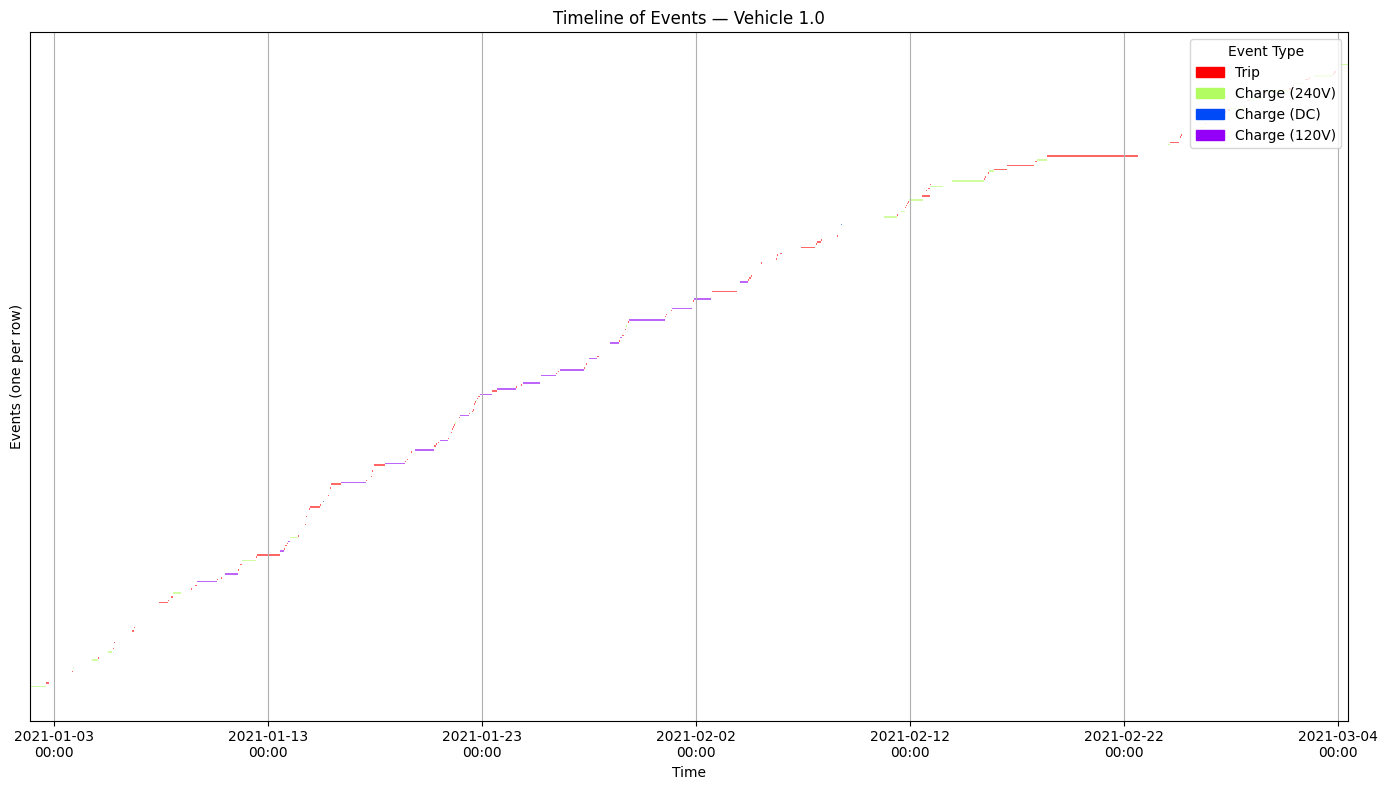

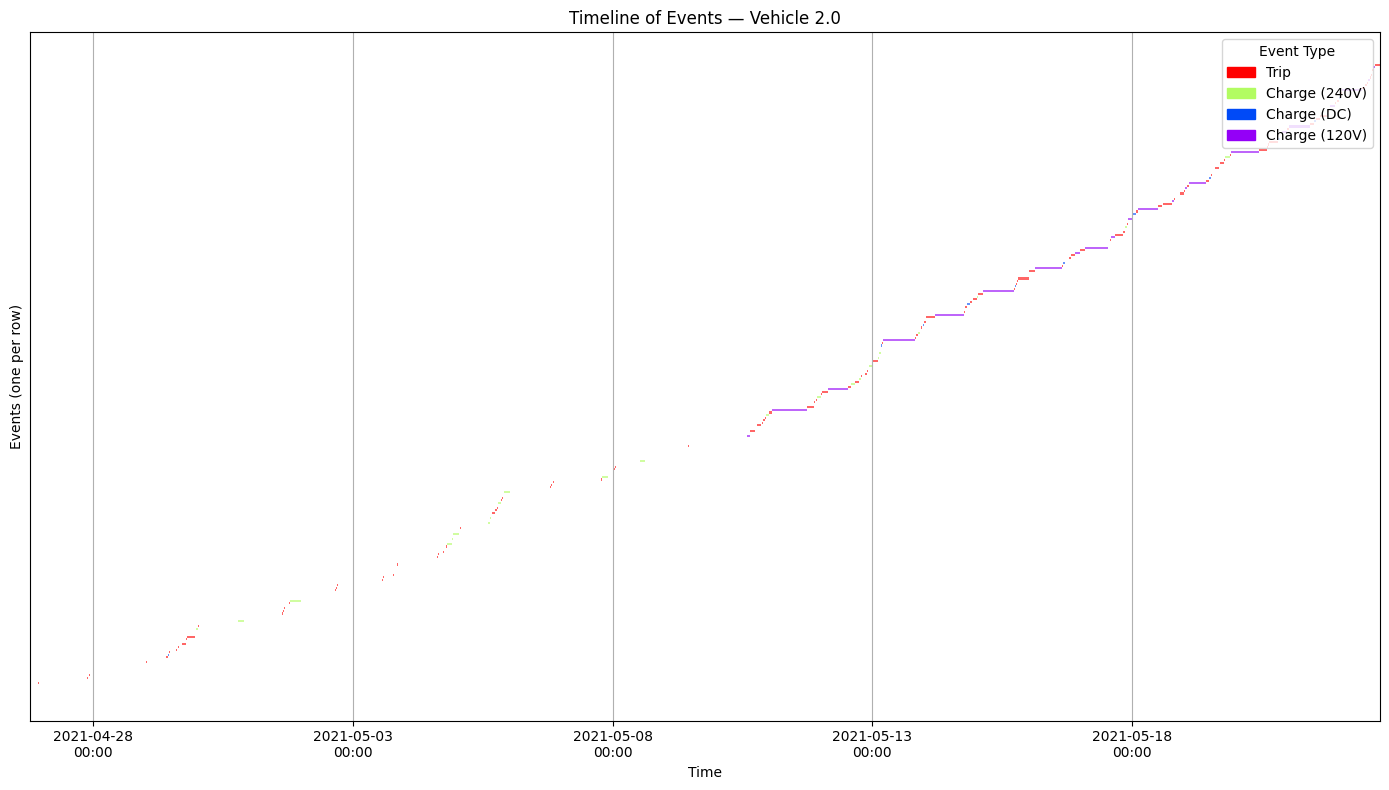

In [1485]:
vehicles = data['vin'].dropna().unique()

for vin in vehicles:
    fig, ax = plt.subplots(figsize=(14, 8))
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    # Calcola il range temporale solo per questo veicolo
    first_data_local = subset['timestamp'].min()
    last_data_local = subset['end_time'].max()

    y_offset = 0
    bar_height = 8

    for _, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue  

        start = mdates.date2num(row['timestamp'])
        end = mdates.date2num(row['end_time'])
        duration = end - start
        color = color_map.get(event_type, 'gray')

        ax.broken_barh(
            [(start, duration)],
            (y_offset, bar_height),
            facecolors=color,
            alpha=0.6
        )
        y_offset += bar_height + 2

    # Limita l’asse X al solo intervallo di tempo del veicolo
    ax.set_xlim(mdates.date2num(first_data_local), mdates.date2num(last_data_local))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Events (one per row)')
    ax.set_title(f'Timeline of Events — Vehicle {vin}')
    ax.grid(True)
    ax.set_yticks([])

    legend_patches = [mpatches.Patch(color=color_map[k], label=v) for k, v in legend_labels.items()]
    ax.legend(handles=legend_patches, title='Event Type', loc='upper right')

    plt.tight_layout()
    plt.show()

In [1486]:
import plotly.graph_objects as go
import pandas as pd

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['event_id'] = range(1, len(data) + 1)





vehicles = data['vin'].dropna().unique()
for vin in vehicles:
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    fig = go.Figure()

    for i, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue


        fig.add_trace(go.Scatter(
            x=[row['timestamp'], row['end_time']],
            y=[i, i],
            mode='lines+markers',
            line=dict(color=color_map[event_type], width=10),
            marker=dict(color=color_map[event_type], size=12),
            name=legend_labels[event_type],
            hovertemplate=f"ID: {row['event_id']}<br>Type: {legend_labels[event_type]}<br>Start: {row['timestamp']}<br>End: {row['end_time']}<extra></extra>",
            showlegend=not any(t.name == legend_labels[event_type] for t in fig.data)
        ))

    fig.update_layout(
        title=f"Interactive Timeline of Events — Vehicle {vin}",
        xaxis_title="Time",
        yaxis_title="Event Index",
        yaxis=dict(autorange="reversed", tickmode='linear'),
        height=600,
        legend_title="Event Type",
        xaxis=dict(
            type='date',
            tickformatstops=[
                dict(dtickrange=[None, 1000 * 60 * 60 * 24], value="%H:%M"),
                dict(dtickrange=[1000 * 60 * 60 * 24, 1000 * 60 * 60 * 24 * 7], value="%d %b"),
                dict(dtickrange=[1000 * 60 * 60 * 24 * 7, None], value="%b %Y")
            ]
        )
    )

    fig.show()

### Analysis of Overlapping Events

In [1487]:

overlapping_events = []
for vm, group in data.sort_values(by='timestamp').groupby('vin'):
    group = group.sort_values(by='timestamp').reset_index(drop=True)
    
    for i in range(1, len(group)):
        prev_end = group.loc[i - 1, 'end_time']
        curr_start = group.loc[i, 'timestamp']
        
        if pd.notna(prev_end) and pd.notna(curr_start) and curr_start < prev_end:
            overlapping_events.append({
                'vehicle': vm,
                'prev_event_id': group.loc[i - 1, 'event_id'],
                'curr_event_id': group.loc[i, 'event_id'],
                'prev_end': prev_end,
                'curr_start': curr_start
            })


overlap_df = pd.DataFrame(overlapping_events)
print(f"🔍 Found {len(overlap_df)} overlapping event pairs.\n")
print(overlap_df)

🔍 Found 3 overlapping event pairs.

   vehicle  prev_event_id  curr_event_id            prev_end  \
0      1.0            420            427 2021-02-12 14:16:00   
1      1.0            428            421 2021-02-12 22:27:00   
2      1.0            425            429 2021-02-13 12:32:00   

           curr_start  
0 2021-02-12 13:52:00  
1 2021-02-12 14:16:00  
2 2021-02-12 22:27:00  


In [1488]:
data.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_preprocessed.csv', index=False)

# OneHotEncoder

In [1489]:
ohe = OneHotEncoder(handle_unknown='ignore')
# Fit the one-hot encoder on training data
cols_to_convert = ['event', 'charge_mode']
ohe.fit(data[cols_to_convert])
# Create a new DataFrame with only the one-hot encoded columns
temp_data = pd.DataFrame(data=ohe.transform(data[cols_to_convert]).toarray(),
                             columns=ohe.get_feature_names_out())
# Create a copy of the DataFrame
data_encoded = data.copy()

# Remove the old categorical columns from the original data
data_encoded.drop(columns=cols_to_convert, axis=1, inplace=True)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), temp_data], axis=1)


In [1490]:
data_encoded.drop(columns=['charge_mode_0'], axis=1, inplace=True)
data_encoded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc  duration  avg_speed  event_id  event_charge  event_trip  \
0   56.4     54.9       7.0  24.241071         1           0.0         1.0   
1   54.9    100.0    1114.0   0.000000         2           1.0         0.0   
2  100.0    100.0       8.0  22.734375         3           0.0         1.0   
3  100.0     94.5     145.0   6.051724         4           0.0         1.0   
4   94.5     94.5       7.0  37.071429         5           0.0         1.0   

   charge_mode_120  charge_mode_240  charge_mode_DCCharging  
0              0.0              0.0                     0.0  
1              0.0              1.0                     0.0  
2              0.0              0.0                     0.0  
3              0.0              0.0                     0.0  
4              0.0              0.0                     0.0

In [1491]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]


# Selecting only numerical columns for correlation
numerical_data = data_encoded[numerical_cols]
vehicles = data_encoded['vin'].unique()


### Feature Correlation Heatmap

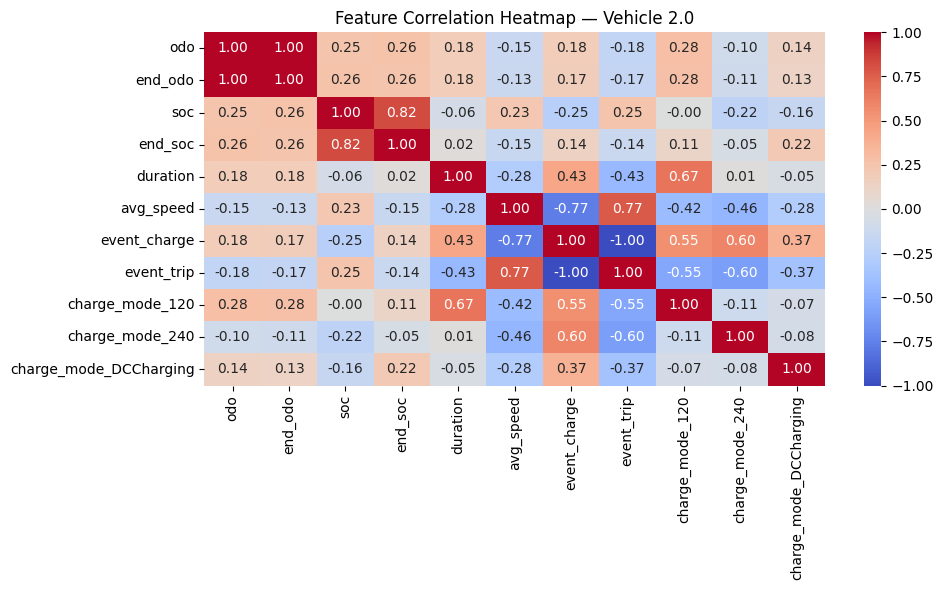

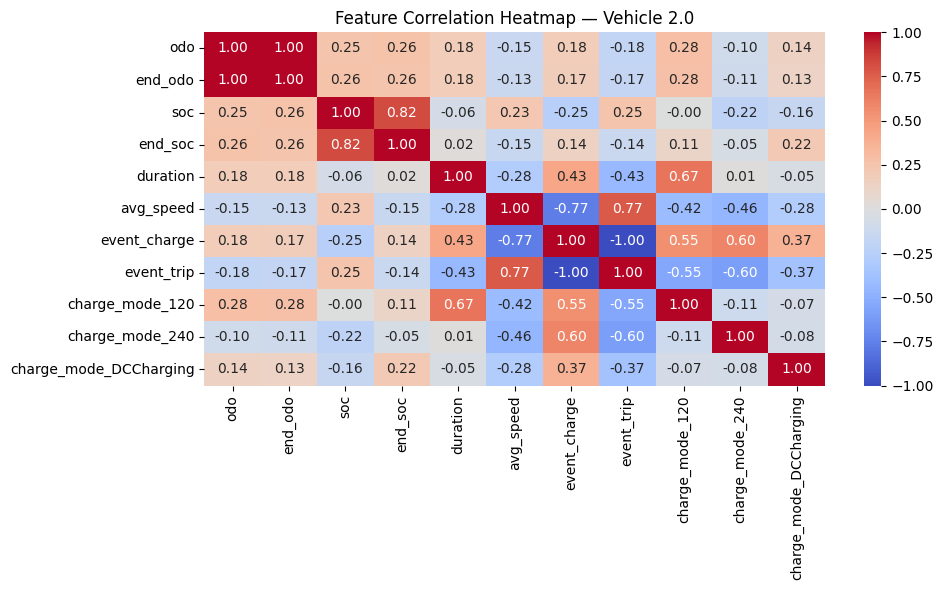

In [1492]:
for vehicle in vehicles:
    subset = data_encoded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()

In [1493]:
data_encoded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_OHE.csv', index=False)

# 2D Embedding

In [1494]:
data_embedded = data.copy()

In [1495]:
data_embedded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          581 non-null    float64       
 1   timestamp    581 non-null    datetime64[ns]
 2   end_time     581 non-null    datetime64[ns]
 3   odo          581 non-null    float64       
 4   end_odo      581 non-null    float64       
 5   soc          581 non-null    float64       
 6   end_soc      581 non-null    float64       
 7   event        581 non-null    category      
 8   charge_mode  581 non-null    category      
 9   duration     581 non-null    float64       
 10  avg_speed    581 non-null    float64       
 11  event_id     581 non-null    int64         
dtypes: category(2), datetime64[ns](2), float64(7), int64(1)
memory usage: 47.0 KB


In [1496]:
data_embedded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc   event charge_mode  duration  avg_speed  event_id  
0   56.4     54.9    trip           0       7.0  24.241071         1  
1   54.9    100.0  charge         240    1114.0   0.000000         2  
2  100.0    100.0    trip           0       8.0  22.734375         3  
3  100.0     94.5    trip           0     145.0   6.051724         4  
4   94.5     94.5    trip           0       7.0  37.071429         5

In [1497]:
# === EMBEDDING PREPARATION ===
import torch
label_encoders = {}
cat_indices = {}
for col in cols_to_convert:
    le = LabelEncoder()
    cat_indices[col + "_idx"] = le.fit_transform(data_embedded[col].astype(str))
    label_encoders[col] = le

data_cat_idx = pd.DataFrame(cat_indices)
X_cat = torch.tensor(data_cat_idx.values, dtype=torch.long)

num_classes_per_cat = [len(label_encoders[col].classes_) for col in cols_to_convert]
embedding_dims = [2 for _ in num_classes_per_cat] 

embedding_layers = nn.ModuleList([
    nn.Embedding(num_embeddings=n, embedding_dim=d)
    for n, d in zip(num_classes_per_cat, embedding_dims)
])


embedded_parts = [embedding_layers[i](X_cat[:, i]) for i in range(X_cat.shape[1])]
embedded_features = torch.cat(embedded_parts, dim=1)  # [num_samples, total_emb_dim]

embedded_feature_names = []
for col, dim in zip(cols_to_convert, embedding_dims):
    embedded_feature_names.extend([f"{col}_emb_{i}" for i in range(dim)])

df_embedded = pd.DataFrame(embedded_features.detach().numpy(), columns=embedded_feature_names)



data_noncat = data_embedded.drop(columns=cols_to_convert).reset_index(drop=True)

data_embedded = pd.concat([data_noncat, df_embedded], axis=1)

In [1498]:
data_embedded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc  duration  avg_speed  event_id  event_emb_0  event_emb_1  \
0   56.4     54.9       7.0  24.241071         1     1.878915    -0.236048   
1   54.9    100.0    1114.0   0.000000         2     0.782835     0.968573   
2  100.0    100.0       8.0  22.734375         3     1.878915    -0.236048   
3  100.0     94.5     145.0   6.051724         4     1.878915    -0.236048   
4   94.5     94.5       7.0  37.071429         5     1.878915    -0.236048   

   charge_mode_emb_0  charge_mode_emb_1  
0           0.995349           0.211423  
1          -0.749232          -0.486325  
2           0.995349           0.211423  
3           0.995349           0.211423  
4           0.995349           0.211423

In [1499]:
cols_to_convert = ['event_emb_0','event_emb_1', 'charge_mode_emb_0', 'charge_mode_emb_1']
data_embedded[cols_to_convert] = data_embedded[cols_to_convert].astype('float64')
data_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   vin                581 non-null    float64       
 1   timestamp          581 non-null    datetime64[ns]
 2   end_time           581 non-null    datetime64[ns]
 3   odo                581 non-null    float64       
 4   end_odo            581 non-null    float64       
 5   soc                581 non-null    float64       
 6   end_soc            581 non-null    float64       
 7   duration           581 non-null    float64       
 8   avg_speed          581 non-null    float64       
 9   event_id           581 non-null    int64         
 10  event_emb_0        581 non-null    float64       
 11  event_emb_1        581 non-null    float64       
 12  charge_mode_emb_0  581 non-null    float64       
 13  charge_mode_emb_1  581 non-null    float64       
dtypes: datetim

In [1500]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_2DE.csv', index=False)

### Timestamp Normalization to Hours Since Start

In [1501]:
#select the least recent date in timestamp
min_date = data_embedded['timestamp'].min()
#compute the difference in hour from the minimum date
data_embedded['timestamp'] = (data_embedded['timestamp'] - min_date).dt.total_seconds() / 3600
data_embedded['end_time'] = (data_embedded['end_time'] - min_date).dt.total_seconds() / 3600

In [1502]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_embedded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

# Selecting only numerical columns for correlation
numerical_data = data_embedded[numerical_cols]
vehicles = data_embedded['vin'].unique()

### Feature Correlation Heatmap

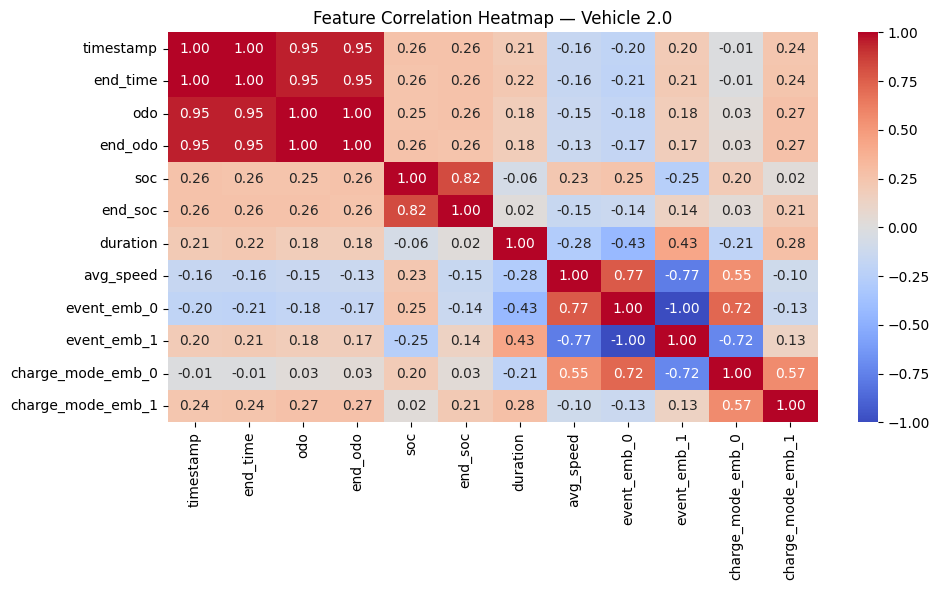

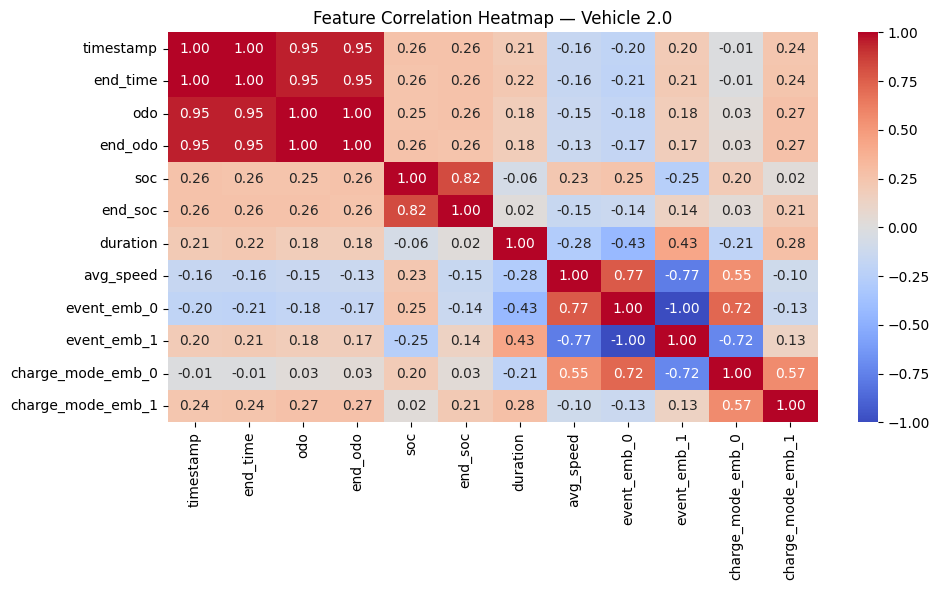

In [1503]:
for vehicle in vehicles:
    subset = data_embedded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()


In [1504]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_2DE_time_norm.csv', index=False)

In [1505]:

data_embedded['event'] = label_encoders['event'].inverse_transform(data_cat_idx['event_idx'])
data_embedded['charge_mode'] = label_encoders['charge_mode'].inverse_transform(data_cat_idx['charge_mode_idx'])


data_from_2DE_to_original = data_embedded.drop(columns=[
    'event_emb_0', 'event_emb_1',
    'charge_mode_emb_0', 'charge_mode_emb_1'
])

In [1506]:
data_from_2DE_to_original.head()

vin  timestamp   end_time          odo     end_odo    soc  end_soc  \
0  1.0   0.000000   0.116667  4436.640625  4439.46875   56.4     54.9   
1  1.0   0.133333  18.700000  4439.468750  4439.46875   54.9    100.0   
2  1.0  18.700000  18.833333  4439.468750  4442.50000  100.0    100.0   
3  1.0  18.833333  21.250000  4442.500000  4457.12500  100.0     94.5   
4  1.0  21.250000  21.366667  4457.125000  4461.45000   94.5     94.5   

   duration  avg_speed  event_id   event charge_mode  
0       7.0  24.241071         1    trip           0  
1    1114.0   0.000000         2  charge         240  
2       8.0  22.734375         3    trip           0  
3     145.0   6.051724         4    trip           0  
4       7.0  37.071429         5    trip           0

In [1507]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data_from_2DE_to_original[col] = data_from_2DE_to_original[col].astype('category')
data_from_2DE_to_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vin          581 non-null    float64 
 1   timestamp    581 non-null    float64 
 2   end_time     581 non-null    float64 
 3   odo          581 non-null    float64 
 4   end_odo      581 non-null    float64 
 5   soc          581 non-null    float64 
 6   end_soc      581 non-null    float64 
 7   duration     581 non-null    float64 
 8   avg_speed    581 non-null    float64 
 9   event_id     581 non-null    int64   
 10  event        581 non-null    category
 11  charge_mode  581 non-null    category
dtypes: category(2), float64(9), int64(1)
memory usage: 47.0 KB
